In [ ]:
pip install gudhi -q

In [ ]:
!pip install scikit-learn==1.4.2 giotto-tda  -q

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gudhi
from tqdm import tqdm
import transformers
from transformers import pipeline
from transformers import BertTokenizer, BertModel
import torch
from __future__ import division
import torch.nn as nn
from typing import Optional, Tuple
import math
import seaborn as sns

import gtda.homology as gtdah
from gtda.time_series import Resampler, SlidingWindow, takens_embedding_optimal_parameters, \
    TakensEmbedding, PermutationEntropy
from gtda.homology import WeakAlphaPersistence, VietorisRipsPersistence
from gtda.diagrams import Scaler, Filtering, PersistenceEntropy, BettiCurve, PairwiseDistance
from gtda.graphs import KNeighborsGraph, GraphGeodesicDistance
from gtda.plotting import plot_heatmap

from sklearn.metrics import pairwise_distances

In [ ]:
import transformers.models.bert.modeling_bert

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

#Sparsemax

In [ ]:
class Sparsemax(nn.Module):
    """Sparsemax function."""

    def __init__(self, device, dim=None):
        """Initialize sparsemax activation

        Args:
            dim (int, optional): The dimension over which to apply the sparsemax function.
        """
        super(Sparsemax, self).__init__()

        self.dim = -1 if dim is None else dim

    def forward(self, input):
        """Forward function.

        Args:
            input (torch.Tensor): Input tensor. First dimension should be the batch size

        Returns:
            torch.Tensor: [batch_size x number_of_logits] Output tensor

        """
        # Sparsemax currently only handles 2-dim tensors,
        # so we reshape to a convenient shape and reshape back after sparsemax
        input = input.transpose(0, self.dim)
        original_size = input.size()
        input = input.reshape(input.size(0), -1)
        input = input.transpose(0, 1)
        dim = 1

        number_of_logits = input.size(dim)

        # Translate input by max for numerical stability
        input = input - torch.max(input, dim=dim, keepdim=True)[0].expand_as(input)

        # Sort input in descending order.
        # (NOTE: Can be replaced with linear time selection method described here:
        # http://stanford.edu/~jduchi/projects/DuchiShSiCh08.html)
        zs = torch.sort(input=input, dim=dim, descending=True)[0]
        range = torch.arange(start=1, end=number_of_logits + 1, step=1, device=device, dtype=input.dtype).view(1, -1)
        range = range.expand_as(zs)

        # Determine sparsity of projection
        bound = 1 + range * zs
        cumulative_sum_zs = torch.cumsum(zs, dim)
        is_gt = torch.gt(bound, cumulative_sum_zs).type(input.type())
        k = torch.max(is_gt * range, dim, keepdim=True)[0]

        # Compute threshold function
        zs_sparse = is_gt * zs

        # Compute taus
        taus = (torch.sum(zs_sparse, dim, keepdim=True) - 1) / k
        taus = taus.expand_as(input)

        # Sparsemax
        self.output = torch.max(torch.zeros_like(input), input - taus)

        # Reshape back to original shape
        output = self.output
        output = output.transpose(0, 1)
        output = output.reshape(original_size)
        output = output.transpose(0, self.dim)

        return output

    def backward(self, grad_output):
        """Backward function."""
        dim = 1

        nonzeros = torch.ne(self.output, 0)
        sum = torch.sum(grad_output * nonzeros, dim=dim) / torch.sum(nonzeros, dim=dim)
        self.grad_input = nonzeros * (grad_output - sum.expand_as(grad_output))

        return self.grad_input


class BertSparseSelfAttention(nn.Module):
    def __init__(self, config, position_embedding_type=None):
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0 and not hasattr(config, "embedding_size"):
            raise ValueError(
                f"The hidden size ({config.hidden_size}) is not a multiple of the number of attention "
                f"heads ({config.num_attention_heads})"
            )

        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)
        self.position_embedding_type = position_embedding_type or getattr(
            config, "position_embedding_type", "absolute"
        )
        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            self.max_position_embeddings = config.max_position_embeddings
            self.distance_embedding = nn.Embedding(2 * config.max_position_embeddings - 1, self.attention_head_size)

        self.is_decoder = config.is_decoder
        self.sparsemax = Sparsemax(device=device)

    def transpose_for_scores(self, x: torch.Tensor) -> torch.Tensor:
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        past_key_value: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        output_attentions: Optional[bool] = False,
    ) -> Tuple[torch.Tensor]:
        mixed_query_layer = self.query(hidden_states)

        # If this is instantiated as a cross-attention module, the keys
        # and values come from an encoder; the attention mask needs to be
        # such that the encoder's padding tokens are not attended to.
        is_cross_attention = encoder_hidden_states is not None

        if is_cross_attention and past_key_value is not None:
            # reuse k,v, cross_attentions
            key_layer = past_key_value[0]
            value_layer = past_key_value[1]
            attention_mask = encoder_attention_mask
        elif is_cross_attention:
            key_layer = self.transpose_for_scores(self.key(encoder_hidden_states))
            value_layer = self.transpose_for_scores(self.value(encoder_hidden_states))
            attention_mask = encoder_attention_mask
        elif past_key_value is not None:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))
            key_layer = torch.cat([past_key_value[0], key_layer], dim=2)
            value_layer = torch.cat([past_key_value[1], value_layer], dim=2)
        else:
            key_layer = self.transpose_for_scores(self.key(hidden_states))
            value_layer = self.transpose_for_scores(self.value(hidden_states))

        query_layer = self.transpose_for_scores(mixed_query_layer)

        use_cache = past_key_value is not None
        if self.is_decoder:
            # if cross_attention save Tuple(torch.Tensor, torch.Tensor) of all cross attention key/value_states.
            # Further calls to cross_attention layer can then reuse all cross-attention
            # key/value_states (first "if" case)
            # if uni-directional self-attention (decoder) save Tuple(torch.Tensor, torch.Tensor) of
            # all previous decoder key/value_states. Further calls to uni-directional self-attention
            # can concat previous decoder key/value_states to current projected key/value_states (third "elif" case)
            # if encoder bi-directional self-attention `past_key_value` is always `None`
            past_key_value = (key_layer, value_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))

        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            query_length, key_length = query_layer.shape[2], key_layer.shape[2]
            if use_cache:
                position_ids_l = torch.tensor(key_length - 1, dtype=torch.long, device=hidden_states.device).view(
                    -1, 1
                )
            else:
                position_ids_l = torch.arange(query_length, dtype=torch.long, device=hidden_states.device).view(-1, 1)
            position_ids_r = torch.arange(key_length, dtype=torch.long, device=hidden_states.device).view(1, -1)
            distance = position_ids_l - position_ids_r

            positional_embedding = self.distance_embedding(distance + self.max_position_embeddings - 1)
            positional_embedding = positional_embedding.to(dtype=query_layer.dtype)  # fp16 compatibility

            if self.position_embedding_type == "relative_key":
                relative_position_scores = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                attention_scores = attention_scores + relative_position_scores
            elif self.position_embedding_type == "relative_key_query":
                relative_position_scores_query = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                relative_position_scores_key = torch.einsum("bhrd,lrd->bhlr", key_layer, positional_embedding)
                attention_scores = attention_scores + relative_position_scores_query + relative_position_scores_key

        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        if attention_mask is not None:
            # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
            attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        attention_probs = self.sparsemax(attention_scores)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        context_layer = torch.matmul(attention_probs, value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_context_layer_shape)

        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)

        if self.is_decoder:
            outputs = outputs + (past_key_value,)
        return outputs


#продолжаем

In [ ]:
transformers.models.bert.modeling_bert.BERT_SELF_ATTENTION_CLASSES["sdpa"] = BertSparseSelfAttention

In [ ]:
transformers.models.bert.modeling_bert.BERT_SELF_ATTENTION_CLASSES

{'eager': transformers.models.bert.modeling_bert.BertSelfAttention,
 'sdpa': __main__.BertSparseSelfAttention}

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased", attn_implementation="sdpa", ).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
text = "Replace me by any text you'd like to answer."
text = "topology is the part of mathematics concerned with the properties of a geometric object that are preserved under continuous deformations, such as stretching, twisting, crumpling, and bending; that is, without closing holes, opening holes"

encoded_input = tokenizer(text, return_tensors='pt')
encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
output = model(**encoded_input, output_attentions=True)

In [ ]:
output.attentions[0].shape

torch.Size([1, 12, 46, 46])

<Axes: >

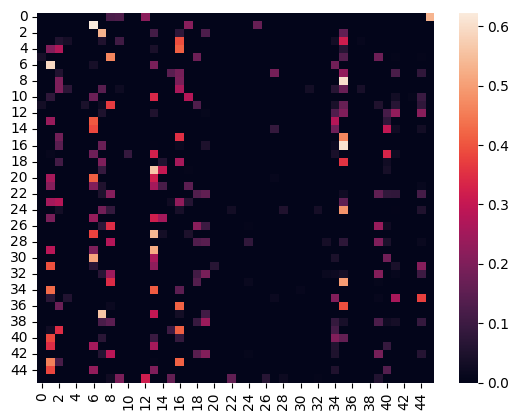

In [ ]:
sns.heatmap(output.attentions[0][0, 0, :, :].cpu().detach().numpy())

In [ ]:
attention = output.attentions[0][0, 0, :, :].cpu().detach().numpy()
attention.shape

(46, 46)

In [ ]:
# attention = adj_matricies[0][0][0]

In [ ]:
attention.shape

(46, 46)

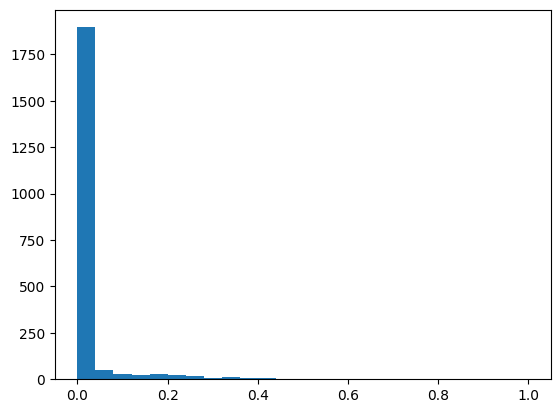

In [ ]:
plt.hist(attention.flatten(), bins = 25, range = (0, 1))
plt.show()

<Axes: >

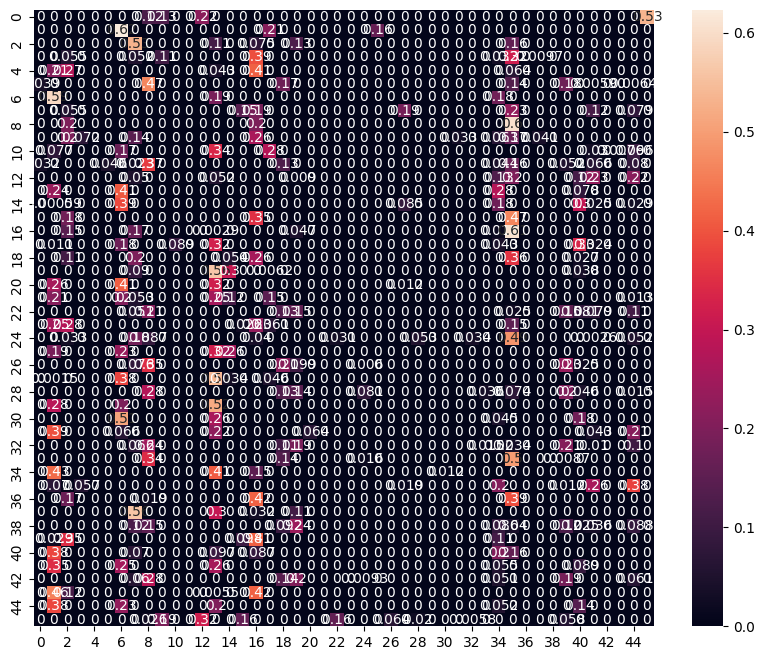

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(attention - np.diag(np.diag(attention)), annot=True)

In [ ]:
att = 1 - attention
att - np.diag(np.diag(att))

array([[0.        , 1.        , 1.        , ..., 1.        , 1.        ,
        0.46555352],
       [1.        , 0.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [1.        , 0.54229915, 0.88102233, ..., 0.        , 1.        ,
        1.        ],
       [1.        , 0.61736643, 1.        , ..., 1.        , 0.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        0.        ]], dtype=float32)

In [ ]:
flagser = gtdah.FlagserPersistence(
    homology_dimensions=(0, 1), directed=True, filtration="max"
)
data = flagser.fit_transform(att - np.diag(np.diag(att))[None, :, :])[0]

In [ ]:
data

array([[0.        , 0.37729788, 0.        ],
       [0.        , 0.39418274, 0.        ],
       [0.        , 0.39528459, 0.        ],
       [0.        , 0.4367252 , 0.        ],
       [0.        , 0.44045788, 0.        ],
       [0.        , 0.46084064, 0.        ],
       [0.        , 0.46555352, 0.        ],
       [0.        , 0.4694072 , 0.        ],
       [0.        , 0.48139578, 0.        ],
       [0.        , 0.48920208, 0.        ],
       [0.        , 0.50378132, 0.        ],
       [0.        , 0.51470435, 0.        ],
       [0.        , 0.53341377, 0.        ],
       [0.        , 0.5341866 , 0.        ],
       [0.        , 0.54229915, 0.        ],
       [0.        , 0.57132733, 0.        ],
       [0.        , 0.58216274, 0.        ],
       [0.        , 0.58274311, 0.        ],
       [0.        , 0.58537978, 0.        ],
       [0.        , 0.58610439, 0.        ],
       [0.        , 0.58794671, 0.        ],
       [0.        , 0.59050477, 0.        ],
       [0.

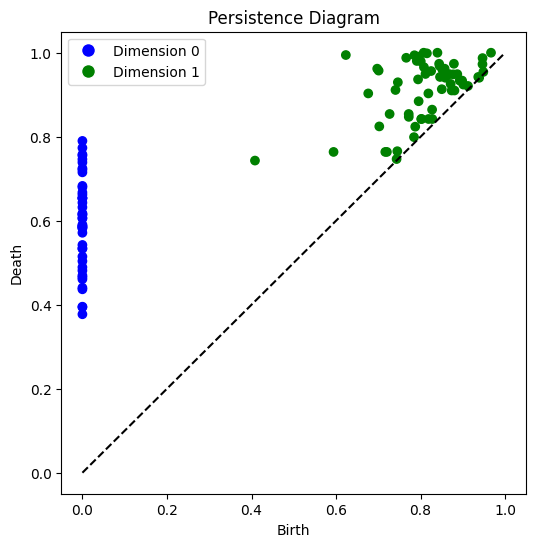

In [ ]:
# Отдельные массивы для рождений и смертей
births = data[:, 0]
deaths = data[:, 1]
dimensions = data[:, 2]

# Установим цвета для различных размерностей
dimension_colors = {0: 'blue', 1: 'green', 2: 'red'}
colors = [dimension_colors[dim] for dim in dimensions]

# Рисуем персистентную диаграмму с различными цветами для разных размерностей
plt.figure(figsize=(6, 6))
scatter = plt.scatter(births, deaths, c=colors, label=[f'Dimension {int(dim)}' for dim in dimensions])
plt.plot([0, 1], [0, 1], 'k--')  # Линия y=x для ориентира
plt.xlabel('Birth')
plt.ylabel('Death')
plt.title('Persistence Diagram')

# Легенда
unique_dims = np.unique(dimensions)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=dimension_colors[dim], markersize=10) for dim in unique_dims]
labels = [f'Dimension {int(dim)}' for dim in unique_dims]
plt.legend(handles, labels)

plt.show()

In [ ]:
st = gudhi.SimplexTree()
for i in range(attention.shape[0]):
  simplex = np.nonzero(attention[i])[0]
  st.insert(simplex)

st.persistence()
st.betti_numbers()[:3]

[1, 2, 0]

In [ ]:
attention = output.attentions[0][0, 0, :, :].cpu().detach().numpy()
for i, attn in enumerate(attention):
    print(f"Layer {i+1} attention shape: {attn.shape}")

Layer 1 attention shape: (46,)
Layer 2 attention shape: (46,)
Layer 3 attention shape: (46,)
Layer 4 attention shape: (46,)
Layer 5 attention shape: (46,)
Layer 6 attention shape: (46,)
Layer 7 attention shape: (46,)
Layer 8 attention shape: (46,)
Layer 9 attention shape: (46,)
Layer 10 attention shape: (46,)
Layer 11 attention shape: (46,)
Layer 12 attention shape: (46,)
Layer 13 attention shape: (46,)
Layer 14 attention shape: (46,)
Layer 15 attention shape: (46,)
Layer 16 attention shape: (46,)
Layer 17 attention shape: (46,)
Layer 18 attention shape: (46,)
Layer 19 attention shape: (46,)
Layer 20 attention shape: (46,)
Layer 21 attention shape: (46,)
Layer 22 attention shape: (46,)
Layer 23 attention shape: (46,)
Layer 24 attention shape: (46,)
Layer 25 attention shape: (46,)
Layer 26 attention shape: (46,)
Layer 27 attention shape: (46,)
Layer 28 attention shape: (46,)
Layer 29 attention shape: (46,)
Layer 30 attention shape: (46,)
Layer 31 attention shape: (46,)
Layer 32 attentio

In [ ]:
output.attentions[11].shape

torch.Size([1, 12, 46, 46])

#...

In [ ]:
import pandas as pd
import re

# from stats_count import *
# from grab_weights import grab_attention_weights, text_preprocessing

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
archive = zipfile.ZipFile('/content/drive/MyDrive/data.zip', 'r')
archive.extractall('/content/data')
archive.close()

In [ ]:
max_tokens_amount  = 128 # The number of tokens to which the tokenized text is truncated / padded.
stats_cap          = 500 # Max value that the feature can take. Is NOT applicable to Betty numbers.

layers_of_interest = [i for i in range(12)]  # Layers for which attention matrices and features on them are
                                             # calculated. For calculating features on all layers, leave it be
                                             # [i for i in range(12)].
stats_name = "s_e_v_c_b0b1" # The set of topological features that will be count (see explanation below)

thresholds_array = [0.025, 0.05, 0.1, 0.25, 0.5, 0.75] # The set of thresholds
thrs = len(thresholds_array)                           # ("t" in the paper)

model_path = tokenizer_path = "bert-base-uncased"

# You can use either standard or fine-tuned BERT. If you want to use fine-tuned BERT to your current task, save the
# model and the tokenizer with the commands tokenizer.save_pretrained(output_dir);
# bert_classifier.save_pretrained(output_dir) into the same directory and insert the path to it here.

In [ ]:
subset = "test_5k"           # .csv file with the texts, for which we count topological features
input_dir = "/content/data/"  # Name of the directory with .csv file
output_dir = "/content/" # Name of the directory with calculations results

prefix = output_dir + subset

r_file     = output_dir + subset  + "_all_heads_" + str(len(layers_of_interest)) + "_layers_MAX_LEN_" + \
             str(max_tokens_amount) + "_" + model_path.split("/")[-1]
# Name of the file for attention matrices weights

stats_file = output_dir + subset + "_all_heads_" + str(len(layers_of_interest)) + "_layers_" + stats_name \
             + "_lists_array_" + str(thrs) + "_thrs_MAX_LEN_" + str(max_tokens_amount) + \
             "_" + model_path.split("/")[-1] + '.npy'
# Name of the file for topological features array

In [ ]:
data = pd.read_csv(input_dir + subset + ".csv").reset_index(drop=True)
data.head()

,Unnamed: 0,id,ended,length,sentence,label
0,4722,259722,True,231,The Learning Co.\n\nDeveloped by\n\nThe Learni...,natural
1,2757,257813,True,563,Bush doubles down on foreign policy on Saturda...,generated
2,2194,257194,True,62,Here are six interesting things you need to kn...,natural
3,817,255817,True,293,Introduction\n\nWe would like to thank Antec f...,natural
4,3886,258886,False,1024,"ELKRIDGE, Md.—A group called ""Muslims for Trum...",natural


In [ ]:
sentences = data['sentence']
print("Average amount of words in example:", \
      np.mean(list(map(len, map(lambda x: re.sub('\w', ' ', x).split(" "), data['sentence'])))))
print("Max. amount of words in example:", \
      np.max(list(map(len, map(lambda x: re.sub('\w', ' ', x).split(" "), data['sentence'])))))
print("Min. amount of words in example:", \
      np.min(list(map(len, map(lambda x: re.sub('\w', ' ', x).split(" "), data['sentence'])))))

Average amount of words in example: 2723.5124
Max. amount of words in example: 6151
Min. amount of words in example: 34


In [ ]:
def get_token_length(batch_texts):
    inputs = tokenizer.batch_encode_plus(batch_texts,
       return_tensors='pt',
       add_special_tokens=True,
       max_length=MAX_LEN,             # Max length to truncate/pad
       pad_to_max_length=True,         # Pad sentence to max length
       truncation=True
    )
    inputs = inputs['input_ids'].numpy()
    n_tokens = []
    indexes = np.argwhere(inputs == tokenizer.pad_token_id)
    for i in range(inputs.shape[0]):
        ids = indexes[(indexes == i)[:, 0]]
        if not len(ids):
            n_tokens.append(MAX_LEN)
        else:
            n_tokens.append(ids[0, 1])
    return n_tokens

In [ ]:
MAX_LEN = max_tokens_amount

In [ ]:
data['tokenizer_length'] = get_token_length(data['sentence'].values)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
data

,Unnamed: 0,id,ended,length,sentence,label,tokenizer_length
0,4722,259722,True,231,The Learning Co.\n\nDeveloped by\n\nThe Learni...,natural,128
1,2757,257813,True,563,Bush doubles down on foreign policy on Saturda...,generated,128
2,2194,257194,True,62,Here are six interesting things you need to kn...,natural,71
3,817,255817,True,293,Introduction\n\nWe would like to thank Antec f...,natural,128
4,3886,258886,False,1024,"ELKRIDGE, Md.—A group called ""Muslims for Trum...",natural,128
...,...,...,...,...,...,...,...
4995,1472,256472,False,1024,"Occasionally, we come across interesting scena...",natural,128
4996,326,255337,False,1024,Providing insight not only into the memes that...,generated,128
4997,3862,258862,True,339,"Each year, MONEY digs into enrollment data and...",natural,128
4998,2862,257862,False,1024,Grounding of the Queen Elizabeth 2 (response) ...,natural,128


In [ ]:
ntokens_array = data['tokenizer_length'].values

In [ ]:
from math import ceil

batch_size = 10 # batch size
number_of_batches = ceil(len(data['sentence']) / batch_size)
DUMP_SIZE = 50 # number of batches to be dumped
batched_sentences = np.array_split(data['sentence'].values, number_of_batches)
number_of_files = ceil(number_of_batches / DUMP_SIZE)
MAX_LEN = max_tokens_amount
adj_matricies = []
adj_filenames = []
assert number_of_batches == len(batched_sentences) # sanity check

In [ ]:
def grab_attention_weights(model, tokenizer, sentences, MAX_LEN, device='cuda:0'):
    inputs = tokenizer.batch_encode_plus([text_preprocessing(s) for s in sentences],
                                       return_tensors='pt',
                                       add_special_tokens=True,
                                       max_length=MAX_LEN,             # Max length to truncate/pad
                                       pad_to_max_length=True,         # Pad sentence to max length)
                                       truncation=True
                                      )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs["token_type_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)
    print('!')
    attention = model(input_ids, attention_mask, token_type_ids, output_attentions=True).attentions
    # layer X sample X head X n_token X n_token
    attention = np.asarray([layer.cpu().detach().numpy() for layer in attention], dtype=np.float16)

    return attention


def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
# for i in tqdm(range(number_of_batches), desc="Weights calc"):
#     attention_w = grab_attention_weights(model, tokenizer, batched_sentences[i], max_tokens_amount, device)
#     # sample X layer X head X n_token X n_token
#     adj_matricies.append(attention_w)
#     if (i+1) % DUMP_SIZE == 0: # dumping
#         print(f'Saving: shape {adj_matricies[0].shape}')
#         adj_matricies = np.concatenate(adj_matricies, axis=1)
#         print("Concatenated")
#         adj_matricies = np.swapaxes(adj_matricies, axis1=0, axis2=1) # sample X layer X head X n_token X n_token
#         filename = r_file + "_part" + str(ceil(i/DUMP_SIZE)) + "of" + str(number_of_files) + '.npy'
#         print(f"Saving weights to : {filename}")
#         adj_filenames.append(filename)
#         np.save(filename, adj_matricies)
#         adj_matricies = []

# if len(adj_matricies):
#     filename = r_file + "_part" + str(ceil(i/DUMP_SIZE)) + "of" + str(number_of_files) + '.npy'
#     print(f'Saving: shape {adj_matricies[0].shape}')
#     adj_matricies = np.concatenate(adj_matricies, axis=1)
#     print("Concatenated")
#     adj_matricies = np.swapaxes(adj_matricies, axis1=0, axis2=1) # sample X layer X head X n_token X n_token
#     print(f"Saving weights to : {filename}")
#     np.save(filename, adj_matricies)

# print("Results saved.")

In [ ]:
from stats_count import *
from grab_weights import grab_attention_weights, text_preprocessing

In [ ]:
stats_name.split("_")

['s', 'e', 'v', 'c', 'b0b1']

In [ ]:
import os
from multiprocessing import Pool
from tqdm import tqdm

adj_filenames = [
    output_dir + filename
    for filename in os.listdir(output_dir) if r_file in (output_dir + filename)
]
# sorted by part number
adj_filenames = sorted(adj_filenames, key = lambda x: int(x.split('_')[-1].split('of')[0][4:].strip()))
adj_filenames

['/content/test_5k_all_heads_12_layers_MAX_LEN_128_bert-base-uncased_part1of5.npy',
 '/content/test_5k_all_heads_12_layers_MAX_LEN_128_bert-base-uncased_part2of5.npy',
 '/content/test_5k_all_heads_12_layers_MAX_LEN_128_bert-base-uncased_part3of5.npy',
 '/content/test_5k_all_heads_12_layers_MAX_LEN_128_bert-base-uncased_part4of5.npy',
 '/content/test_5k_all_heads_12_layers_MAX_LEN_128_bert-base-uncased_part5of5.npy']

In [ ]:
num_of_workers = 20
pool = Pool(num_of_workers)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
# adj_matricies = np.load('/content/test_5k_all_heads_12_layers_MAX_LEN_128_bert-base-uncased_part1of5.npy', allow_pickle=True)

In [ ]:
attention = np.array([
    [0, 1, 1, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0],
    [1, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 1, 0, 1, 0, 0],
    [0, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1]
])

In [ ]:
attention = np.random.normal(size = (10,10))

In [ ]:
# Проба через gudhi
import gc
thresholds_array = [0.1, 0.2, 0.3, 0.5]
betti = []

for threshold in thresholds_array:
  attention_thresholded = np.where(attention > threshold, attention, 0)

  st = gudhi.SimplexTree()
  for j in range(attention_thresholded.shape[0]):
      simplex = np.nonzero(attention_thresholded[j])[0]
      if len(simplex) > 0:  # Только добавляем непустые симплексы
          st.insert(simplex)

  st.persistence()
  betti.append(st.betti_numbers())

  del attention_thresholded, st, simplex
  gc.collect()

In [ ]:
betti

[[1, 0, 1, 0], [1, 3, 1, 0], [1, 3, 1, 0], [1, 4, 0, 0]]

In [ ]:
# Проба через simplicialx
import gc
thresholds_array = [0.1, 0.2, 0.3, 0.5]
betti = []

for threshold in thresholds_array:
  attention_thresholded = np.where(attention > threshold, attention, 0)

  D_row = SimplicialComplex()
  for i, row in enumerate(attention_thresholded):
      sigma = np.nonzero(row)[0]
      if len(sigma) != 0:
        D_row.add(sigma)

  betti.append(D_row.betti())

  del attention_thresholded, D_row, sigma
  gc.collect()

In [ ]:
betti

array([[1., 0., 1.],
       [1., 3., 1.],
       [1., 3., 1.],
       [1., 4., 0.]])

In [ ]:
betti_array = np.array(betti)

# Находим индексы столбцов, которые не являются полностью нулевыми
non_zero_columns = np.any(betti_array != 0, axis=0)

# Удаляем все нулевые столбцы
betti = betti_array[:, non_zero_columns]

betti_numbers shape: (4, 3)
thresholds_array length: 4


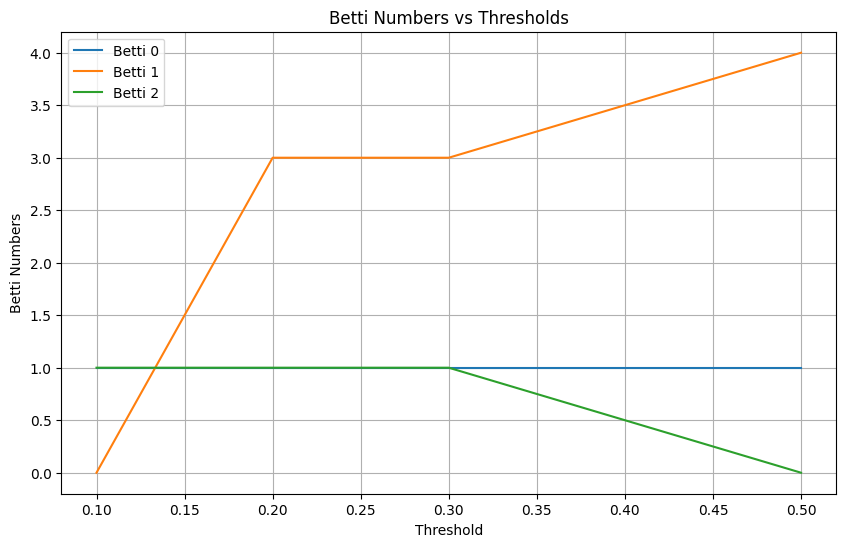

In [ ]:
betti = np.array(betti)

# Проверим размеры массивов
print(f"betti_numbers shape: {betti.shape}")
print(f"thresholds_array length: {len(thresholds_array)}")

# Убедимся, что размеры совпадают
assert betti.shape[0] == len(thresholds_array), "Mismatch between betti_numbers and thresholds_array sizes"

# Транспонируем массив, чтобы удобно работать с размерностями
betti = betti.T

# Построим график
plt.figure(figsize=(10, 6))

# Линии для каждой размерности
for dim in range(betti.shape[0]):
    b = betti[dim, :]
    plt.plot(thresholds_array, b, label=f'Betti {dim}')

# Настройка графика
plt.xlabel('Threshold')
plt.ylabel('Betti Numbers')
plt.title('Betti Numbers vs Thresholds')
plt.legend()
plt.grid(True)
plt.show()
betti = betti.T

#simplicial test

In [ ]:
# add 0-simplices (vertices)
v1 = cmplx.addSimplex(id="v1")
v2 = cmplx.addSimplex(id="v2")
v3 = cmplx.addSimplex(id="v3")
v4 = cmplx.addSimplex(id="v4")
v5 = cmplx.addSimplex(id="v5")
v6 = cmplx.addSimplex(id="v6")
v7 = cmplx.addSimplex(id="v7")

In [ ]:
# add 1-simplices (edges)
cmplx.addSimplex(['v2', 'v3'], id="e1")
cmplx.addSimplex(['v4', 'v5'], id="e2")
cmplx.addSimplex(['v4', 'v6'], id="e3")
cmplx.addSimplex(['v5', 'v6'], id="e4")
cmplx.addSimplex(['v5', 'v7'], id="e5")
cmplx.addSimplex(['v6', 'v7'], id="e6")

'e6'

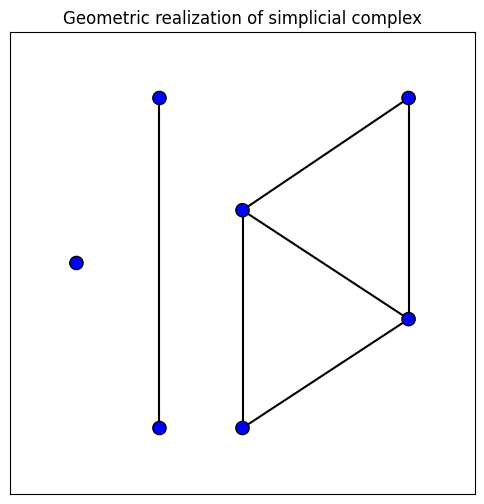

In [ ]:
# set coordinates for vertices
em = Embedding(cmplx)
em.positionSimplex(v1, (0.0, 0.5))

em.positionSimplex(v2, (0.25, 1.0))
em.positionSimplex(v3, (0.25, 0.0))

em.positionSimplex(v4, (1.0, 1.0))
em.positionSimplex(v5, (0.5, 0.66))
em.positionSimplex(v6, (1.0, 0.33))
em.positionSimplex(v7, (0.5, 0.0))

# draw simplicial complex
fig = plt.figure(figsize=(6,6))
plt.title("Geometric realization of simplicial complex")
draw_complex(cmplx, em)

In [ ]:
# evaluate complex dimension
dim = cmplx.maxOrder()

# evaluate Betti numbers
betti = cmplx.bettiNumbers()

In [ ]:
print("Dimension of complex: {}".format(dim))
for key in betti:
    if key <= dim:
        print("Betti-{}: {}".format(str(key), betti[key]))

Dimension of complex: 1
Betti-0: 3
Betti-1: 2


In [ ]:
# add 2-simplex (triangle)
cmplx.addSimplex(['e2', 'e3', 'e4'], id="t1")

't1'

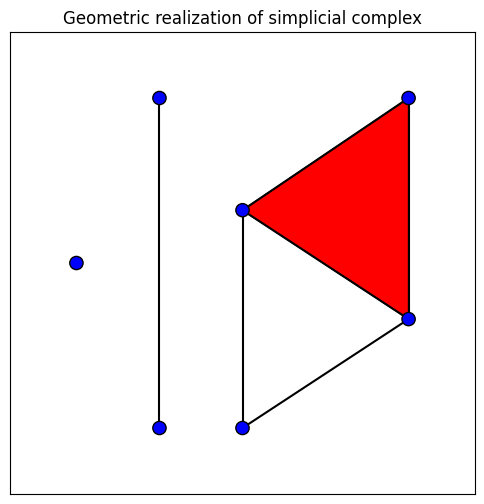

In [ ]:
# draw simplicial complex
fig = plt.figure(figsize=(6,6))
plt.title("Geometric realization of simplicial complex")
draw_complex(cmplx, em)

#Draw_complex simplicial

In [ ]:
# Drawing routines for simplicial complexes
#
# Copyright (C) 2017 Simon Dobson
#
# This file is part of simplicial, simplicial topology in Python.
#
# Simplicial is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# Simplicial is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with Simplicial. If not, see <http://www.gnu.org/licenses/gpl.html>.

# from simplicial import *

import collections

import matplotlib as mpl
import matplotlib.pyplot as plt

def draw_complex( c, em, ax = None, color = None, color_simplex = None, node_size = 0.02 ):
    '''Draw a simplicial complex.

    At present we only deal with simplices of order 2 and less.

    :param c: the complex
    :param em: embedding providing the positions of the 0-simplices
    :param ax: the axes to draw in (defaults to main axes)
    :param color: an array of colours for the different simplex orders (defaults to a "reasonable" scheme)
    :param color_simplex: a function from complex, simplex and order to a colour (defaults to order color)
    :param node_size: the size of the node (0-simplex) markers'''

    # fill in the argument defaults where not specified
    if ax is None:
        # main figure axes
        ax = plt.gca()
    no = c.maxOrder()
    if color is None:
        # a simple colour scheme that seems to work
        color = [ 'blue', 'black', 'red' ]
    else:
        if isinstance(color, collections.Sequence):
            # make sure we have enough colours for all the simplex orders
            if len(color) < no:
                color.append([ 'blue' ] * ((no + 1) - len(color)))
    if color_simplex is None:
        # no per-node colours, default to the color array
        color_simplex = lambda a, b, o: color[o]

    # set up the axes
    ax.set_xlim([-0.2, 1.2])      # axes bounded around 1
    ax.set_ylim([-0.2, 1.2])
    ax.grid(False)                # no grid
    ax.get_xaxis().set_ticks([])  # no ticks on the axes
    ax.get_yaxis().set_ticks([])

    # draw the node markers
    for s in c.simplicesOfOrder(0):
        (x, y) = em[s]
        #print (x, y)
        circ = plt.Circle([ x, y ],
                          radius = node_size,
                          edgecolor = 'black', facecolor = color_simplex(c, s, 0),
                          zorder = 3)
        ax.add_patch(circ)

    # draw the edges
    for s in c.simplicesOfOrder(1):
        fs = list(c.basisOf(s))
        (x0, y0) = em[fs[0]]
        (x1, y1) = em[fs[1]]
        line = plt.Line2D([ x0, x1 ], [y0, y1 ],
                          color = 'black', # color = color_simplex(c, s, 1),
                          zorder = 2)
        ax.add_line(line)

    # fill in the triangles
    for s in c.simplicesOfOrder(2):
        fs = list(c.basisOf(s))
        (x0, y0) = em[fs[0]]
        (x1, y1) = em[fs[1]]
        (x2, y2) = em[fs[2]]
        tri = plt.Polygon([ [ x0, y0 ], [ x1, y1 ], [ x2, y2 ] ],
                          edgecolor = 'black', facecolor = color_simplex(c, s, 2),
                          zorder = 1)
        ax.add_patch(tri)


#Embedding simplicial

In [ ]:
# An embedding of a simplicial complex into a space
#
# Copyright (C) 2017 Simon Dobson
#
# This file is part of simplicial, simplicial topology in Python.
#
# Simplicial is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# Simplicial is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with Simplicial. If not, see <http://www.gnu.org/licenses/gpl.html>.

import math
import itertools

# from simplicial import *


class Embedding(object):
    '''The abstract embedding of a simplicial complex into a space. An embedding
    associates a position with each 0-simplex in the complex, allowing spatial calculations
    to be performed.

    Embeddings serve two distinct purposes. Firstly, they admit spatial calculations
    as well as purely topological ones, which broadens the application areas to which
    we can apply simplicial ideas. Secondly, embeddings form the basis for visualisation,
    as they allow points (0-simplices) in a complex to be associated with points in
    an n-dimensional embedding space. This can result in more meaingful diagrams.

    An embedding can be specified in two distinct ways. Positions can be supplied
    explicitly for simplices by name. Alternatively, sub-clases can provide positioning
    functions that map simplices to positions using arbitrary code. The former is useful
    for complexes with irregular embeddings, while the latter is better-suited to
    regular embeddings. Explicit positions override computed positions, which allows
    small distortions to be applied easily to otherwise regular embeddings.

    It is also possible to override the distane metrioc to construct different ways
    of metricating a space.

    Note that in most cases an embedding is based on simplex names, and so care needs to
    be taken when relabeling simplices in the underlying complex.

    :param c: the complex
    :param dim: the dimension of the embedding space (defaults to 2)

    '''

    def __init__( self, c, dim = 2 ):
        self._complex = c          # underlying complicial complex
        self._dim = dim            # dimension of embedding space
        self._position = dict()    # cache of positions

    def dimension( self ):
        '''Return the dimension of the embedding space.

        :retirns: the dimension of the embedding space'''
        return self._dim

    def origin( self ):
        '''Return the position of the origin of the embedding space.

        :returns: the origin as a list of zero co-ordinates'''
        return [ 0.0 ] * self.dimension()

    def complex( self ):
        '''Return the underlying simplicial complex.

        :returns: the complex'''
        return self._complex

    def distance(self, p, q ):
        '''Compute the distance between two points. This implementation
        returns the normal Euclidean distance metric.

        :param p: one point
        :param q: the other point
        :returns: the distance between them'''
        sumsq = 0.0
        for d in range(self.dimension()):
            sumsq = sumsq + math.pow(q[d] - p[d], 2)
        return math.sqrt(sumsq)


    # ----- Positioning simplices -----

    def positionSimplex( self, s, pos ):
        '''Define an explicit position for a simplex.

        :param s: the simplex
        :param pos: the position'''

        # check dimensions of position
        if len(pos) != self.dimension():
            raise ValueError("Providing a {pd}-dimensional position for an {ed}-dimensional embedding space".format(pd = len(pos),
                                                                                                                    ed = self.dimension()))
        self._position[s] = pos

    def positionOf( self, s ):
        '''Return the position of a simplex in the complex when mapped through this
        embedding. Locations are only available for 0-simplices.

        :param s: the simplex
        :returns: the position of the simplex'''

        # check that we're being asked for an 0-simplex
        if self.complex().orderOf(s) > 0:
            raise ValueError("Can only embed 0-simplices")

        if s not in self._position.keys():
            # no explicit position, so compute it and cache the result
            self._position[s] = self.computePositionOf(s)
        return self._position[s]

    def computePositionOf( self, s ):
        '''Compute the position of the given 0-simplex under this embedding.
        The position returned should have the same dimensions as the
        embedding space. This method should be overridden by sub-classes:
        the default returns the origin for all 0-simplices.

        :param s: the simplex
        :returns: the position of the simplex'''
        return self.origin()

    def positionsOf( self, ss = None ):
        '''Return a dict of positions for a given set of 0-simplices
        in the complex. The default is to return the positions of all
        0-simplices.

        :param ss: the simplices (defaults to all 0-simplices)
        :returns: a dict of positions'''

        # fill in default
        if ss is None:
            ss = self.complex().simplicesOfOrder(0)

        # retrieve positions and return
        pos = dict()
        for s in ss:
            pos[s] = self.positionOf(s)
        return pos

    def clearPositions( self ):
        '''Clear the cache of simplex positions, forcing them all to be re-computed
        and/or re-specified. Use this if the underlying complex is changed.'''
        self._position = dict()


    # ----- dict-like interface -----

    def __len__( self ):
        '''The length of the embedding is the number of 0-simplices in the underlying
        simplicial complex, i.e., the number of simplices we can return positions for.

        :returns: the size of the embedding'''
        return self.complex().simplicesOfOrder(0)

    def __setitem__( self, s, pos ):
        '''Dict-like interface to define an explicit position for a simplex.
        Equivalent to :meth:`positionSimplex`.

        :param s: the simplex
        :param pos: the position'''
        self.positionSimplex(s, pos)

    def __getitem__( self, s ):
        '''Dict-like interface to return the position of a simplex in the
        complex when mapped through this embedding. Equivalent to :meth:`positionOf`.

        :param s: the simplex
        :returns: the position of the simplex'''
        return self.positionOf(s)

    def __contains__( self, s ):
        '''Test if the embedding will embed the given simplex. Checks against the
        underlying simplicial complex.

        :param s: the simplex
        :returns: True if the embedding comtains the simplex'''
        return s in self.complex().simplicesOfOrder(0)


    # ----- Spatial constructions -----
    # sd: will be re-written to use M-trees

    def vietorisRipsComplex( self, eps ):
        '''Construct the :term:`Vietoris-Rips complex` at scale eps corresponding to the
        given embedding. The resulting complex has the same 0-simplices as the
        embedding, with a simplex constructed beyween every collection of simplices
        that are mutually a distance eps or less apart.

        :param eps: the scale parameter
        :returns: the Vietoris-Rips complex at the given scale'''

        # create a new complex with the same 0-simplices as ourselves
        c = self.complex()
        vr = SimplicialComplex()
        ss = list(c.simplicesOfOrder(0))
        for s in ss:
            vr.addSimplex(id = s)

        # work out all pairs of 0-simplices within eps, adding a
        # 1-simplex between them
        n = len(ss)
        for i in range(n - 1):
            p = ss[i]
            for j in range(i + 1, n):
                q = ss[j]
                if self.distance(self.positionOf(p), self.positionOf(q)) <= eps:
                    # pair of 0-simplices within eps, add 1-simplex
                    vr.addSimplexWithBasis([p, q])

        # add higher simplices for collections of 0-simplices
        # mutally within eps, which is simply the flag complex
        # derived from the pairwise distances
        vr2 = vr.flagComplex()

        # return the populated complex
        return vr2


#SimplicialComplex simplicial

In [ ]:
# Base class for simplicial complexes
#
# Copyright (C) 2017 Simon Dobson
#
# This file is part of simplicial, simplicial topology in Python.
#
# Simplicial is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# Simplicial is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with Simplicial. If not, see <http://www.gnu.org/licenses/gpl.html>.

import numpy
import copy
import itertools


class SimplicialComplex(object):
    '''A finite abstract simplicial complex.

    A simplicial :term:`complex` is a generalisation of a network in which
    vertices (0-simplices) and edges (1-simplices) can be composed
    into triangles (2-simplices), tetrahedrons (3-simplices) and so
    forth. This class actually implements closed simplicial complexes
    that contain every simplex, every :term:`face` of that simplex, every face
    of those simplices, and so forth. Operations to add and remove
    simplices cascade to keep the complex closed: if a simplex is an
    element of a complex, then all its faces are also elements, and so
    on recursively.

    The class also includes some topological operations, notably for
    computing the :term:`Euler characteristic` of a complex and
    performing Euler integration, and for computational :term:`homology`.

    '''

    # ---------- Initialisation and helpers ----------

    def __init__( self ):
        self._sequence = 1           # sequence number for generating simplex names
        self._simplices = dict()     # dict from simplex to faces
        self._attributes = dict()    # dict from simplex to attributes
        self._faces = dict()         # dict from simplex to simplices of which it is a face

    def _newUniqueIndex( self, d ):
        '''Generate a new unique identifier for a simplex. The default naming
        scheme uses a sequence number and a leading dimension indicator. Users
        can name simplices anything they want to get meaningful names.

        :param d: dimension of the simplex to be identified
        :returns: an identifier not currently used in the complex'''
        i = self._sequence
        while True:
            id = '{dim}d{id}'.format(dim = d, id = i)
            if id not in self._simplices.keys():
                self._sequence = i + 1
                return id
            else:
                i = i + 1

    def _orderIndices( self, ls ):
        '''Return the list of simplex indices in a canonical order. (The
        exact order doesn't matter, it simply ensures consistent naming.)

        :param ls: a list of simplex names
        :returns: the simplex names in canonical order'''
        return sorted(ls)


    # ---------- Adding simplices ----------

    def addSimplex( self, fs = [], id = None, attr = None, ignoreDuplicate = False ):
        '''Add a simplex to the complex whose faces are the elements of fs.
        If no faces are given then the simplex is a 0-simplex (point).
        If no id is provided one is created. If present, attr should be a
        dict of attributes for the simplex.

        If ignoreDuplicate is False, n exception will be thrown if a simplex
        with the given faces already exists in the complex. If ignoreDuplicate is
        true, the new simplex will be ignored.

        To add a simplex from its basis (rather than its faces) use
        :meth:`addSimplexByBasis`.

        :param fs: (optional) a list of faces of the simplex
        :param id: (optional) name for the simplex
        :param attr: (optional) dict of attributes
        :param ignoreDuplicate: if True, silently drop addition of duplicate simplex
        :returns: the name of the new simplex'''

        # fill in defaults
        if id is None:
            # no identifier, make one
            id = self._newUniqueIndex(max(len(fs) - 1, 0))
        else:
            # check we've got a new id
            if id in self._simplices.keys():
                raise Exception('Duplicate simplex {id}'.format(id = id))
        if attr is None:
            # no attributes
            attr = dict()

        # we need at least two faces, defining at least a 1-simplex, since
        # 0-simplices don't have any faces
        if len(fs) == 1:
            raise Exception('Need at least two faces, defining a 1-simplex')

        # place faces into canonical order
        ofs = self._orderIndices(fs)

        # sanity check that we know all the faces, and that they're all of the
        # correct order to be faces of this simplex
        os = len(ofs) - 1
        for f in ofs:
            if f not in self._simplices.keys():
                raise Exception('Unknown simplex {id}'.format(id = f))
            of = self.orderOf(f)
            if of != os - 1:
                raise Exception('Face {id} is of order {of}, not {os}'.format(id = f,
                                                                              of = of,
                                                                              os = os - 1))

        # sanity check that we don't already have a simplex with these faces
        if os > 0:
            s = self.simplexWithFaces(ofs)
            if s is not None:
                if ignoreDuplicate:
                    # simplex exists but ignoring duplicates, so exit
                    return
                else:
                    raise Exception('Already have a simplex {s} with faces {ofs}'.format(s = s,
                                                                                         ofs = ofs))

        # add simplex and its attributes
        self._simplices[id] = ofs
        self._attributes[id] = attr
        self._faces[id] = []

        # record the faces
        for f in ofs:
            self._faces[f].append(id)

        # return the simplex' name
        return id

    def addSimplexWithBasis( self, bs, id = None, attr = None, ignoreDuplicate = False ):
        '''Add a simplex by providing its basis, which uniquely defines it.
        This method adds all the simplices necessary to define the new
        simplex, using :meth:`simplexByBasis` to find and re-use any that are
        already in the complex.

        To add a simplex defined by its faces, use :meth:`addSimplex`.

        If ignoreDuplicate is False, n exception will be thrown if a simplex
        with the given basis already exists in the complex. If ignoreDuplicate is
        true, the new simplex will be ignored.

        Defining a k-simplex requires a (k + 1) basis. All elements of
        the basis must be 0-simplices.

        :param bs: the basis
        :param id: (optional) the name of the new simplex
        :param attr: (optional) dict of attributes
        :param ignoreDuplicate: if True, silently drop addition of duplicate simplex
        :returns: the name of the new simplex'''
        so = len(bs) - 1   # order of the final simplex
        fs = []            # faces in the final simplex

        # make sure the list is a basis
        for b in bs:
            if b in self._simplices.keys():
                # simplex exists, check it's an 0-simplex
                if self.orderOf(b) > 0:
                    raise Exception('Higher-order simplex {s} in basis set'.format(s = b))
                else:
                    s = b
            else:
                # simplex doesn't exist, create it
                s = self.addSimplex(id = b)

                # if we're creating an 0-simplex, we're now done
                if so == 0:
                    return s

            # capture the simplex as a face if we're building a 1-simplex
            if so == 1:
                fs.append(s)

        # check if we have a simplex with this basis
        s = self.simplexWithBasis(bs)
        if s is not None:
            if ignoreDuplicate:
                # duplicate simplex and we're ignoring, so return
                return s
            else:
                raise Exception('Simplex {s} with basis {bs} already exists'.format(s = s,
                                                                                    bs = bs))

        # create a name for the new simplex if needed
        if id is None:
            id = self._newUniqueIndex(so)

        # iterate up through all the simplex orders, creating
        # any missing ones and capturing the faces for the final simplex
        for k in xrange(1, so):
            # find all the bases for the simplices of this order
            bss = set(itertools.combinations(bs, k + 1))
            for pbs in bss:
                # do we have the simplex with this basis?
                s = self.simplexWithBasis(pbs)
                if s is None:
                    # no, create it
                    s = self.addSimplexWithBasis(pbs)

                # if we're at the final order, capture the simplex as a face
                if k == so - 1:
                    fs.append(s)

        # create the final simplex and return it
        s = self.addSimplex(id = id,
                            fs = fs,
                            attr = attr)
        return s

    def addSimplexOfOrder( self, o, id = None ):
        '''Add a new simplex, disjoint from all others, with the given order.
        This will create all the necessary faces and so on down to a new
        basis.

        :param o: the order of the new simplex
        :param id: (optional) name of the new simplex
        :returns: the name of the new simplex'''
        if o == 0:
            # it's an 0-simplex, just try to create a new one
            return self.addSimplex(id = id)
        else:
            # create a basis of new names
            bs = []
            for i in xrange(o + 1):
                bs.append(self._newUniqueIndex(0))

            # create the new simplex and return it
            return self.addSimplexWithBasis(bs, id)

    def addSimplicesFrom( self, c, rename = None ):
        '''Add simplices from the given complex. The rename parameter
        is an optional mapping of the names in c that can be provided
        as a dict of old names to new names or a function from names
        to names.

        If the relabeling is a dict it may be incomplete, in which
        case simplices retain their names.  (If the relabeling is a
        function, it has to handle all names.)

        This operation is equivalent to copying the other complex,
        re-labeling it using :meth:`relabel` and then copying it
        into this complex directly. The caveats on attributes
        containing simplex names mentioned in respect to :meth:`relabel`
        apply to :meth:`addSimplicesFrom` too.

        :param c: the other complex
        :param rename: (optional) renaming dict or function
        :returns: a list of simplex names'''

        # fill-out the defaults
        if rename is None:
            f = lambda s: s
        else:
            if isinstance(rename, dict):
                f = lambda s: rename[s] if s in rename.keys() else s
            else:
                f = rename

        # perform the copy, renaming the nodes as they come in
        ns = []
        for s in c.simplices():
            t = f(s)
            if s != t and t in self._simplices.keys():
                raise Exception('Copying attempting to re-write {s} to the name of an existing simplex {t}'.format(s = s, t = t))
            id = self.addSimplex(id = t,
                                 fs = map(f, c.faces(s)),
                                 attr = c[s])
            ns.append(id)
        return ns


    # ---------- Relabelling ----------

    def relabel( self, rename ):
        '''Re-label simplices using the given relabeling, which may be a
        dict from old names to new names or a function taking a name
        and returning a new name.

        If the relabeling is a dict it may be incomplete, in which
        case unmentioned simplices retain their names. (If the relabeling is a
        function, it has to handle all names.)

        In both cases, :meth:`relabel` will complain if the relabeling
        generates as a "new" name a name already in the complex. (This
        detection isn't completely foolproof: just don't do it.) If you want
        to unify simplices, use :meth:`unifyBasis` instead.

        (Be careful with attributes: if a simplex has an attribute the
        value of which is the name of another simplex, then renaming
        will destroy the connection and lead to problems.)

        :param rename: the relabeling, a dict or function
        :returns: a list of new names used

        '''

        # force the map to be a function
        if isinstance(rename, dict):
            f = lambda s: rename[s] if s in rename.keys() else s
        else:
            f = rename

        # perform the renaming
        newSimplices = dict()
        newFaces = dict()
        newAttributes = dict()
        for s in self._simplices.keys():
            t = f(s)
            if s != t and self.containsSimplex(t):
                raise Exception('Relabeling attempting to re-write {s} to existing name {t}'.format(s = s, t = t))
            newSimplices[t] = map(f, self._simplices[s])
            newFaces[t] = map(f, self._faces[s])
            newAttributes[t] = copy.copy(self._attributes[s])

        # replace the old names with the new
        self._simplices = newSimplices
        self._faces = newFaces
        self._attributes = newAttributes

        # return the new names of all the simplices
        return self.simplices()


    # ---------- Deleting simplices ----------

    def _deleteSimplex( self, s ):
        '''Delete a simplex. This can result in a broken complex, so
        it's almost always better to use :meth:`deleteSimplex`.

        :param s: the simplex'''

        # delete the simplex from the face lists of its faces
        ts = self.faces(s)
        for t in ts:
            self._faces[t].remove(s)

        # delete the simplex' elements
        del self._simplices[s]
        del self._attributes[s]
        del self._faces[s]

    def deleteSimplex( self, s ):
        '''Delete a simplex and all simplices of which it is a part.

        :param s: the simplex'''
        for t in self.partOf(s, reverse = True):
            # delete in decreasing order, down to the basis
            self._deleteSimplex(t)

    def deleteSimplices( self, ss ):
        '''Delete all simplices in the given list.

        :param ss: the simplices'''
        for s in ss:
            # protect against unfortunate cascades of deletions
            if self.containsSimplex(s):
                self.deleteSimplex(s)

    def __delitem__( self, s ):
        '''Delete the simplex and all simplices of which it is a part.
        Equivalent to :meth:`deleteSimplex`.

        :param s: the simplex'''
        self.deleteSimplex(s)

    def restrictBasisTo( self, bs ):
        '''Restrict the complex to include only those simplices whose
        bases are wholly contained in the given set of 0-simplices.

        :param bs: the basis
        :returns: the complex'''
        bs = set(bs)

        # make sure we have a set of 0-simplices
        for s in bs:
            if self.orderOf(s) > 0:
                raise Exception('Higher-order simplex {s} in basis set'.format(s = s))

        # find all simplices that need to be excluded
        remove = set([])
        for s in self._simplices:
            if self.orderOf(s) == 0:
                # it's a vertex, is it in the set?
                if s not in bs:
                    # no, mark it for dropping
                    remove.add(s)
            else:
                # it's a higher-order simplex, is its basis wholly in the set?
                sbs = self.basisOf(s)
                if not sbs <= bs:
                    # basis is not wholly contained, mark it for removal
                    remove.add(s)

        # close the set of simplices to be removed
        for r in remove:
            rs = remove.union(self.partOf(r))

        # remove the marked simplices
        for s in self._orderSortedSimplices(remove, reverse = True):
            self._deleteSimplex(s)


    # ---------- Accessing simplices ----------

    def orderOf( self, s ):
        '''Return the order of a simplex.

        :param s: the simplex
        :returns: the order of the simplex'''''
        return max(len(self.faces(s)) - 1, 0)

    def maxOrder( self ):
        '''Return the largest order of simplices in the complex, that is
        to say, the largest order for which a call to :meth:`simplicesOfOrder`
        will return a non-empty list.

        :returns: the largest order that contains at least one simplex, or None'''
        if len(self._simplices) == 0:
            return None
        else:
            os = [ self.orderOf(s) for s in self._simplices ]
            return max(os)

    def numberOfSimplicesOfOrder( self ):
        '''Return a dict mapping an order to the number of simplices
        of that order in the complex.

        :returns: a dict mapping order to number of simplices'''
        orders = dict()
        for s in self._simplices:
            o = self.orderOf(s)
            if o not in orders:
                orders[o] = 1
            else:
                orders[o] = orders[o] + 1
        return orders

    def _orderCmp( self, s, t ):
        '''Comparison function for simplices based on their order.

        :param s: the first simplex
        :param t: the second simplex
        :returns: -1, 0, 1 for less than, equal, greater than'''
        return cmp(self.orderOf(s), self.orderOf(t))

    def _orderSortedSimplices( self, ss, reverse = False ):
        '''Return the list of simplices sorted into increasing order
        of their order, or decreasing order if revere is True.
        :param ss: the simplices
        :param reverse: (optional) sort in decreasing order
        :returns: the list of simplices in increasing/decreasing order of order'''
        # return sorted(ss, cmp = lambda s, t: self._orderCmp(s, t), reverse = reverse)
        return sorted(ss, key = lambda s: self.orderOf(s), reverse = reverse)

    def simplices( self, reverse = False ):
        '''Return all the simplices in the complex. The simplices come
        out in order of their orders, so all the 0-simplices
        first, then all the 1-simplices, and so on: if the reverse
        parameter is `True`, then the order is reversed.

        :param reverse: (optional) reverse the sort order if True
        :returns: a list of simplices'''
        return self._orderSortedSimplices(self._simplices, reverse)

    def simplicesOfOrder( self, o ):
        '''Return all the simplices of the given order. This will
        be empty for any order not returned by :meth:`orders`.

        :param o: the desired order
        :returns: a set of simplices, which may be empty'''
        ss = []
        for s in self._simplices:
            if max(len(self.faces(s)) - 1, 0) == o:
                ss.append(s)
        return set(ss)

    def simplexWithBasis( self, bs ):
        '''Return the simplex with the given basis, if it exists
        in the complex. All elements of the basis must be 0-simplices.

        :param bs: the basis
        :returns: the simplex or None'''

        # sanity check
        for s in bs:
            if self.orderOf(s) > 0:
                raise Exception('Higher-order simplex {s} in basis set'.format(s = s))

        # check for a simplex with the given basis
        so = len(bs) - 1
        ss = None
        for s in bs:
            ps = set([ p for p in self.partOf(s) if self.orderOf(p) == so ])
            if ss is None:
                ss = ps
            else:
                ss &= ps
            if len(ss) == 0:
                # no way to get a simplex, bail out
                return None

        # if we get here, we've found the simplex
        # sd: should we check that the set size is 1, just for safety?
        return ss.pop()

    def simplexWithFaces( self, fs ):
        '''Return the simplex that has the given simplices as faces.

        :param fs: the faces
        :returns: the simplex or None'''

        # get the order of simplex we're searching for
        k = len(fs) - 1

        # check that the faces have a common order and are the right number
        if k <= 0:
            # not enough faces
            raise Exception('Need at least 1 face')
        else:
            # check all faces are of order (k - 1)
            for f in fs:
                if self.orderOf(f) != k - 1:
                    raise Exception('Simplex of order{k} has faces of order {kmo}, not {fo}'.format(k = k,
                                                                                                    kmo = k - 1,
                                                                                                    fo = self.orderOf(f)))

        # search for simplex
        ffs = set(fs)
        for s in self.simplicesOfOrder(k):
            sfs = self.faces(s)
            if sfs == ffs:
                return s

        # if we get here, we didn't find a simplex with the right faces
        return None

    def containsSimplex( self, s ):
       '''Test whether the complex contains the given simplex.

       :param s: the simplex
       :returns: True if the simplex is in the complex'''
       return (s in self._simplices.keys())

    def containsSimplexWithBasis( self, bs ):
        '''Test whether the complex contains a simplex with the given basis.

        :params bs: the basis
        :returns: True is the complex contains a simplex with this basis'''
        return (self.simplexWithBasis(bs) is not None)

    def allSimplices( self, p, reverse = False ):
        '''Return all the simplices that match the given predicate, which should
        be a function from complex and simplex to boolean. The simplices are
        sorted according to their orders.

        :param p: a predicate
        :param reverse: (optional) reverse the order
        :returns: the set of simplices satisfying the predicate'''
        return self._orderSortedSimplices([ s for s in self._simplices if p(self, s) ], reverse)


    # ---------- Attributes ----------

    def __getitem__( self, s ):
        '''Return the attributes associated with the given simplex.

        :param s: the simplex
        :returns: a dict of attributes'''
        return self._attributes[s]

    def __setitem__( self, s, attr ):
        '''Set the attributes associated with a simplex.

        :param s: the simplex
        :param attr: the attributes'''
        self._attributes[s] = attr


    # ---------- Structure of complex, per-simplex level ----------

    def faces( self, s ):
        '''Return the faces of a simplex.

        :param s: the simplex
        :returns: a set of faces'''
        return set(self._simplices[s])

    def faceOf( self, s ):
        '''Return the simplices that the given simplex is a face of. This
        is not transitive: all the simplices returned will be of an order
        one greater than the given simplex. The transitive closure of
        :meth:`faceOf` is :meth:`partOf`.

        :param s: the simplex
        :returns: a list of simplices'''''
        return self._faces[s]

    def partOf( self, s, reverse = False, exclude_self = False ):
        '''Return the transitive closure of all simplices of which the simplex
        is part: a face of, or a face of a face of, and so forth. This is
        the dual of :meth:`closureOf`. If exclude_self is False (the default),
        the set include the simplex itself.

        In some of the topology literature this operation is called the star.

        :param s: the simplex
        :param reverse: (optional) reverse the sort order
        :param exclude_self: (optional) exclude the simplex itself (default to False)
        :returns: the list of simplices the simplex is part of'''
        if exclude_self:
            parts = set()
        else:
            parts = set([ s ])
        fs = self._faces[s]
        for f in fs:
            parts |= set(self.partOf(f))
        return self._orderSortedSimplices(parts, reverse)

    def basisOf( self,  s ):
        '''Return the basis of a simplex, the set of 0-simplices that
        define its faces. The length of the basis is equal to one more
        than the order of the simplex.

        :param s: the simplex
        :returns: the set of simplices that form the basis of s'''

        # sd: not the most elegant way to do this....
        return set([ f for f in self.closureOf(s) if self.orderOf(f) == 0 ])

    def closureOf( self, s, reverse = False, exclude_self = False ):
        '''Return the closure of a simplex. The closure is defined
        as the simplex plus all its faces, transitively down to its basis.
        If exclude_self is True, the closure excludes the simplex itself.

        :param s: the simplex
        :param reverse: (optional) reverse the sort order
        :param exclude_self: (optional) exclude the simplex itself (defaults to False)
        :returns: the closure of the simplex'''

        def _close( t ):
            fs = self.faces(t)
            if len(fs) == 0:
                # 0-simplex, return it
                return set([ t ])
            else:
                # k-simplex, return a list of it and its faces
                faces = set()
                for f in fs:
                    faces = faces.union(_close(f))
                faces = faces.union(set([ t ]))
                return faces

        ss = _close(s)
        if exclude_self:
            ss.remove(s)
        return self._orderSortedSimplices(ss, reverse)


    # ---------- Euler characteristic and integration ----------

    def  eulerCharacteristic( self ):
        '''Return the Euler characteristic of this complex, which is a
        measure of its topological structure.

        :returns: the Euler characteristic'''
        euler = 0
        orders = self.numberOfSimplicesOfOrder()
        for o, n in orders.iteritems():
            euler = euler + pow(-1, o) * n
        return euler

    def eulerIntegral( self, observation_key = 'height' ):
        '''Perform an Euler integraton across a simplicial complex
        using the value of a particular attribute.

        :param c: the complex
        :param observation_key: the attribute to integrate over (defaults to 'height')'''

        # compute maximum "height"
        maxHeight = max([ self[s][observation_key] for s in self.simplices() ])

        # perform the integration over the level sets
        a = 0
        for s in xrange(maxHeight + 1):
            # form the level set
            # sd TODO: the level set is uniformly growing as s decreases, so we can optimise?
            cprime = copy.deepcopy(self)
            bs = cprime.allSimplices(lambda c, sp: self.orderOf(sp) == 0 and
                                                   self[sp][observation_key] > s)
            cprime.restrictBasisTo(bs)

            # compute the Euler characteristic of the level set
            chi = cprime.eulerCharacteristic()
            #print 'level {level}, chi = {chi}'.format(level = s, chi = chi)

            # add to the integral
            a = a + chi

        # return the accumulated integral
        return a


    # ---------- Homology ----------

    def boundary( self, ss ):
        '''Return the boundary of the given p-chain. This will be a (p - 1)-chain
        of simplices from the complex.

        :param ss: a chain (list) of simplices
        :returns: the boundary of the chain'''
        bs = set()
        p = None
        for s in ss:
            if p is None:
                # first simplex, work out the order of p-chain we're looking at
                p = self.orderOf(s)
            else:
                # later simplex, make sure it's the right order
                if self.orderOf(s) != p:
                    raise Exception('{p}-chain contains simplex of order {q}'.format(p = p,
                                                                                     q = self.orderOf(s)))

            # extract the boundary of this simplex
            fs = self.faces(s)

            # any simplices in both sets aren't in the boundary; any not
            # in the boundary should be added
            bs ^= fs
        return bs

    def boundaryMatrix( self, k ):
        '''Return the :term:`boundary operator` of the k-simplices in the
        complex as a `numpy` matrix. The columns correspond to
        simplices of order k while rows correspond to simplices
        of order (k - 1). The matrix has a 1 when a (k - 1) simplex
        is a face of the corresponding k-simplex, and 0 otherwise.

        The boundary of the 0-simplices is a matrix with one row,
        all zeros. The boundary of an order greater than the maximum
        order of the complex is a 0x0 matrix.

        :param k: the order of simplices
        :returns: the boundary matrix'''

        # extract simplices at this order
        n = self.numberOfSimplicesOfOrder()

        # if we're after order 0, return  a row of zeros
        if k == 0:
            return numpy.zeros([ 1, n[k] ])

        # if we're after an order greater than our maximum order, return a zero matrix
        if k > self.maxOrder():
            return numpy.zeros([ 0, 0 ])

        # form a canonical ordering for the simplics of order k and k - 1
        ks = self._orderSortedSimplices(self.simplicesOfOrder(k))
        kmos = self._orderSortedSimplices(self.simplicesOfOrder(k - 1))

        # create a zero boundary matrix
        boundary = numpy.zeros([ n[k - 1], n[k] ])

        # add 1 in every row which is a face of the column' simplex
        c = 0
        for s in ks:
            # extract the faces of the simplex
            for f in self.faces(s):
                # mark the corresponding position with a 1
                r = kmos.index(f)
                boundary[r, c] = 1
            c = c + 1

        return boundary

    def disjoint( self, ss ):
        '''Test whether the elements of a set of simplices are disjoint,
        defined as if they share no common simplices in their closures.
        (This doesn't mean that they aren't part of a common super-simplex,
        however.) The simplices need not be of the same order, i.e., need
        not form a p-chain.

        :param ss: the p-chain
        :returns: boolean'''
        cl = None
        for s in ss:
            if cl is None:
                # first simplex, grab its closure
                cl = set(self.closureOf(s))
            else:
                # next simplex, check for intersection of closure
                clprime = set(self.closureOf(s))
                if cl.isdisjoint(clprime):
                    # closures are disjoint, unify them
                    cl = cl.update(clprime)
                else:
                    # closures intersect, we fail
                    return False

        # if we get here, all the simplices were disjoint
        return True

    def smithNormalForm( self, B ):
        '''Reduce a boundary matrix to Smith Normal Form, which has a leading diagonal
        of 1s for some number of rows, and is everywhere else zero.

        :param b: the boundary matrix to reduce
        :returns: the Smith Normal Form of the boundary matrix'''
        return self._reduce(B, 0)

    def _reduce( self, Bin, x = 0 ):
        '''Reduce a boundary matrix to Smith Normal Form.
        The algorithm is taken from `here <https://www.cs.duke.edu/courses/fall06/cps296.1/Lectures/sec-IV-3.pdf>`_. NOte that this is simpler than other algorithms in the literature because
        we're working over a binary field.

        :param b: the boundary matrix to reduce
        :param x: the row/column being reduced, initially 0
        :returns: the Smith Normal Form of the boundary matrix'''

        # check we're still in scope
        (rb, cb) = Bin.shape
        if x >= min([ rb, cb ]):
            # no, return the reduced matrix
            return Bin

        #  check if we have another row to reduce
        for k in range(x, rb):
            for l in range(x, cb):
                if Bin[k, l] == 1:
                    # yes, make a copy of the matrix
                    B = Bin.copy()

                    # exchange rows x and k
                    B[[x, k], :] = B[[k, x], :]

                    # exchange columns x and l
                    B[:, [x, l]] = B[:, [l, x]]

                    # zero the x column in subsequent rows
                    for i in range(x + 1, rb):
                        if B[i, x] == 1:
                            B[i, :] = (B[i, :] + B[x, :]) % 2

                    # ...and the x row in subsequent columns
                    for j in range(x + 1, cb):
                        if B[x, j] == 1:
                            B[:, j] = (B[:, j] + B[:, x]) % 2

                    # move to the next row
                    return self._reduce(B, x + 1)

        # if we get here, we're fully reduced
        return Bin

    def bettiNumbers( self, ks = None ):
        '''Return a dict of Betti numbers for the different dimensions
        of the complex.

        :param ks: (optional) dimensions to compute (defaults to all)
        :returns: a dict of Betti numbers'''

        # fill in the default
        if ks is None:
            ks = range(self.maxOrder() + 1)

        # compute the Betti numbers
        boundary = dict()
        betti = dict()
        for k in ks:
            # compute the reduced boundary operator matrices if we
            # haven't already done so
            if k not in boundary.keys():
                boundary[k] = self.smithNormalForm(self.boundaryMatrix(k))
            A = boundary[k]
            if k + 1 not in boundary.keys():
                boundary[k + 1] = self.smithNormalForm(self.boundaryMatrix(k + 1))
            B = boundary[k + 1]

            # dimensions of boundary matrices
            (ra, ca) = A.shape
            (rb, cb) = B.shape

            # compute the ranks of the Z_k and B_k groups
            zc = numpy.zeros(ra)
            kernelDim = [ numpy.all(A[:, j] == zc) for j in range(ca) ].count(True) # zero columns
            zr = numpy.zeros(cb)
            imageDim = [ numpy.all(B[i, :] == zr) for i in range(rb) ].count(False) # non-zero rows
            betti[k] = kernelDim - imageDim

        return betti


    # ---------- Derived copmplexes ----------

    def _isClosed( self, boundary, fs ):
        '''Determine whether the given set of (k + 1) faces forms the
        boundary of a k-simplex according to the boundary operator.
        The faces are given by indices into the boundary matrix. They
        are closed if, when we sum the columns corresponding to them,
        the result consists of values that are either 2 or 0, i.e., if
        every face connects either 0 or 2 simplices.

        :param boundary: the boundary matrix
        :param fs: list of face indices
        :returns: True if the faces form a closed k-simplex'''

        # extract and sum columns
        s = numpy.sum(boundary[:, fs], axis = 1)

        # check we only have 2 or 0 in all positions
        return numpy.all(numpy.logical_or(s == 2, s == 0))

    def flagComplex( self ):
        '''Generate the :term:`flag complex` of this complex. The flag complex
        is formed by creating all the "implied" simplices for which all
        faces are present. For example, three 1-simplices forming an
        (empty) triangle will be "closed" by creating a 2-simplex
        with them as its faces. This may in turn allow a further
        3-simplex to be formed if the new 2-simplex closes a tetrahedron,
        and so forth.

        :returns: the flag complex'''

        # start with a copy of ourselves
        flag = copy.copy(self)

        # work up the simplex orders
        k = 1           # we use 1-simplices as adjacencies
        added = 1
        while added > 0:
            k = k + 1
            added = 0

            # compute the boundary operator
            boundary = self.boundaryMatrix(k - 1)

            # test all (k + 1) (k - 1)-simplices to see if they form
            # a boundary
            ks = numpy.array(self._orderSortedSimplices(self.simplicesOfOrder(k - 1)))
            for fs in [ list(fs) for fs in itertools.combinations(range(len(ks)), k + 1) ]:
                if self._isClosed(boundary, fs):
                    # simplices form a boundary, add to the
                    # flag complex (if it doesn't already exist)
                    cfs = ks[fs]
                    if flag.simplexWithFaces(cfs) is None:
                        flag.addSimplex(fs = cfs)
                        added = added + 1

        return flag


#SimplicialComplex simplicialX

In [ ]:
from itertools import combinations

class SimplicialComplex:
    __slots__ = [
        '_simplices',
        '_weights',
        '_kind',
        '_hasse',
        # caches
        '_cache_bom',
        '_cache_lg',
    ]

    # ========== INITIALIZATION AND ATTRIBUTES ========== #

    def __init__(self):
        self._simplices: list[np.ndarray] = []
        self._weights: dict = {}
        self._kind = None
        self._hasse = None
        # caches
        self._cache_bom: dict = {}
        self._cache_lg: dict = {}

    @property
    def simplices(self):
        return self._simplices

    @property
    def weights(self):
        return self._weights

    @property
    def kind(self):
        return self._kind

    @property
    def hasse_graph(self):
        if self._hasse is not None:
            return self._hasse.copy()
        return None

    @simplices.setter
    def simplices(self, new_simplices):
        if new_simplices == []:
            self.clear()

        else:
            _check_n_simpl_complex(new_simplices)

            simplices = []
            weights = {}
            dim = len(new_simplices) - 1

            for iteration in range(dim + 1):
                simplices.append(np.sort(np.unique(np.array(new_simplices[iteration]), axis=0)).astype('int'))

            for i in range(dim + 1):
                smps = simplices[i]
                for simplex in smps:
                    weights[tuple(simplex)] = 1.

            self._simplices = simplices
            self._weights = weights
            self._cache_bom = {}
            self._cache_lg = {}

    @weights.setter
    def weights(self, new_weights):
        _check_weights(new_weights)

        dim = len(self._simplices) - 1

        for i in range(dim + 1):
            simplices = self._simplices[i]

            for simplex in simplices:
                if tuple(simplex) not in new_weights.keys():
                    raise ValueError('Weights must be specified for all simplices in the complex')

        self._weights = new_weights

    @kind.setter
    def kind(self, new_kind):
        if new_kind is not None:
            _check_kind(new_kind)

        self._kind = new_kind

    # ========== PROPERTIES ========== #

    @property
    def f_vector(self):
        res = [s.shape[0] for s in self._simplices]
        return np.array(res).astype('int')

    @property
    def euler_characteristic(self) -> int:
        alternating_sign = np.array([(-1) ** i for i in range(len(self._simplices))])
        res = self.f_vector @ alternating_sign
        return res.astype('int')

    @property
    def dim(self):
        res = len(self._simplices) - 1
        if res < 0:
            return None
        return res

    @property
    def simplices_num(self) -> int:
        res = np.sum(self.f_vector)
        return res.astype('int')

    def __len__(self) -> int:
        return self.simplices_num

    # ========== MODIFYING FUNCTIONS ========== #

    def clear(self):
        self._simplices = []
        self._weights = {}
        self._kind = None
        self._hasse = None
        self._cache_bom = {}
        self._cache_lg = {}

    def copy(self):
        res = SimplicialComplex()

        res._simplices = self._simplices.copy()
        res._weights = self._weights.copy()
        res.kind = self.kind
        if self._hasse is not None:
            res._hasse = self._hasse.copy()

        return res

    def add(self, simplex, weight=1):
        if isinstance(simplex, (list, tuple)):
            simplex = np.array(simplex)
        _check_simplex(simplex)
        if not isinstance(weight, (float, int)):
            raise TypeError('Incorrect type of weight: must be int or float')

        k = simplex.shape[0] - 1
        dim = len(self._simplices) - 1

        if k <= dim and simplex.tolist() in self._simplices[k].tolist():
            return

        self._hasse = None
        self._cache_bom = {}
        self._cache_lg = {}

        for i in range(min(k + 1, dim + 1)):
            self._simplices[i] = self._simplices[i].tolist()

        if k > dim:
            for i in range(dim + 1, k + 1):
                self._simplices.append([])

        for i in range(k + 1):
            for face in combinations(simplex, i + 1):
                sub_s = list(face)

                if sub_s in self._simplices[i]:
                    continue

                self._simplices[i].append(sub_s)
                self._weights[tuple(sub_s)] = 1.

                # TODO:
                '''
                if self._hasse is not None:
                    self._add_hasse(sub_s, i-1)
                '''

            self._simplices[i] = np.unique(np.array(self._simplices[i]), axis=0).astype('int')

        self._weights[tuple(simplex)] = weight

    def remove(self, simplex):
        if isinstance(simplex, (list, tuple)):
            simplex = np.array(simplex)
        _check_simplex(simplex)

        k = simplex.shape[0] - 1
        dim = len(self._simplices) - 1

        if dim < k or simplex.tolist() not in self._simplices[k].tolist():
            return

        self._hasse = None
        self._cache_bom = {}
        self._cache_lg = {}

        for i in range(k, dim + 1):
            self._simplices[i] = self._simplices[i].tolist()

        for i in range(dim, k - 1, -1):
            cofaces = self._cofaces(simplex, i)

            for coface in cofaces:
                s = list(coface)
                self._simplices[i].remove(s)
                self._weights.pop(tuple(s), None)

                # TODO:
                '''
                if self._hasse is not None:
                    self._hasse.remove_node(tuple(s))
                '''

            if not self._simplices[i]:
                self._simplices = self._simplices[:i]
            else:
                self._simplices[i] = np.array(self._simplices[i]).astype('int')

    def update(self, simplex, weight=1):
        if isinstance(simplex, (list, tuple)):
            simplex = np.array(simplex)
        _check_simplex(simplex)
        if not isinstance(weight, (float, int)):
            raise TypeError('Incorrect type of weight: must be int or float')

        n = simplex.shape[0] - 1
        _check_simplex_in_complex(self._simplices[n], simplex)

        self._weights[tuple(simplex)] = weight

    def weight_threshold(self, threshold):
        if not isinstance(threshold, (float, int)):
            raise TypeError('Incorrect type of threshold: must be int or float')

        dim = len(self._simplices) - 1

        for i in range(dim, 0, -1):
            for simplex in self._simplices[i]:
                if self._weights[tuple(simplex)] < threshold:
                    self.remove(simplex)

    # Tech Funcs #

    def _add_hasse(self, s_list, n):
        k = len(s_list) - 1
        order = k - n

        if n < 0 or order <= 0:
            return

        faces = self._faces(s_list, n)
        for face in faces:
            self._hasse.add_edge(tuple(face), tuple(s_list), order=order, kind="coboundary")
            self._hasse.add_edge(tuple(s_list), tuple(face), order=order, kind="boundary")

    # ========== SERIALIZING FUNCTIONS ========== #

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            return pickle.load(f)

    # ========== BUILDING COMPLEX ========== #

    @classmethod
    def from_graph(cls, graph, kind='clique', n_skeleton=2, weighted=False):
        if isinstance(graph, nx.classes.graph.Graph):
            X = nx.to_numpy_array(graph)
        else:
            _check_adjacency_matrix(graph)
            X = graph.copy()
        np.fill_diagonal(X, 0)

        res = cls()
        res.kind = kind

        n_skeleton = _check_integer_values(n_skeleton=n_skeleton)
        if n_skeleton < 0:
            raise ValueError('Incorrect value of n_skeleton: must be >= 0')

        # main part

        if kind == 'clique':

            if not weighted:
                res._simplices = res._get_clique_complex_vr(X, n_skeleton)

                weights = {}
                dim = len(res._simplices) - 1

                for i in range(dim + 1):
                    simplices = res._simplices[i]
                    for simplex in simplices:
                        weights[tuple(simplex)] = 1.

                res._weights = weights

            else:
                res._simplices, res._weights = res._get_weighted_clique_complex(X, n_skeleton)

        elif kind == 'neighborhood':
            res._simplices, res._weights = res._get_neighborhood_dowker_complex(X, n_skeleton, weighted)

        elif kind == 'dowker':
            res._simplices, res._weights = res._get_neighborhood_dowker_complex(X, n_skeleton, weighted, nb=False)

        return res

    # Tech Funcs #

    def _get_neighborhood_dowker_complex(self, X, n_skeleton, weighted, nb=True):
        X_cur = X.copy()

        N, res, res_weights = X_cur.shape[0], [[]], {}

        if nb:
            np.fill_diagonal(X_cur, 1)

        for i in range(N):
            res[0].append([i])
            res_weights[tuple([i])] = 1.

        res[0] = np.array(res[0])

        row_ind, row = X_cur.nonzero()

        for iteration in range(1, n_skeleton + 1):
            res.append([])

            for i in range(N):
                simplex = row[row_ind == i]
                n = simplex.shape[0]
                if n - 1 - iteration < 0:
                    continue
                subsimplex_arr = self._get_subsimplex_array(simplex, diff=n - 1 - iteration)
                res[iteration] += list(subsimplex_arr)

            res[iteration] = np.sort(np.unique(np.array(res[iteration]), axis=0)).astype('int')

            if len(res[iteration]) == 0:
                res.pop()
                break

            for simplex in res[iteration]:
                if not weighted:
                    res_weights[tuple(simplex)] = 1.

                else:

                    if iteration == 1:
                        res_weights[tuple(simplex)] = X[simplex[0]][simplex[1]]

                    else:
                        weight = -np.inf

                        for prev_simplex in self._get_subsimplex_array(simplex):
                            prev_simplex_weight = res_weights[tuple(prev_simplex)]
                            weight = np.maximum(weight, prev_simplex_weight)

                        res_weights[tuple(simplex)] = weight

        return res, res_weights

    def _get_clique_complex_vr(self, X, n_skeleton):

        n_skeleton = n_skeleton + 1

        def _add_cofaces(A, k, tau, N_lower, simplices):

            simplices.append(tau)

            if len(tau) >= k:
                return

            else:
                for v in N_lower:
                    sigma = sorted(tau + [v])
                    M = _intersect([N_lower, _neighbors_lower(v, A)])
                    _add_cofaces(A, k, sigma, M, simplices)

            return simplices

        def _neighbors_lower(x_id, A):
            LT = np.tril(A)
            return list(np.nonzero(LT[x_id])[0])

        def _intersect(d):
            return list(set(d[0]).intersection(*d))

        def _grade(K):
            dim = len(max(K, key=len))
            K_graded = [[] for _ in range(dim)]

            for sigma in K:
                dim_sigma = len(sigma) - 1

                if dim_sigma == 0:
                    sigma = sigma[0]
                K_graded[dim_sigma].append(sigma)

            for k, item in enumerate(K_graded):
                if k == 0:
                    item_array = np.expand_dims(np.array(item), 1)
                else:
                    item_array = np.array(item)

                K_graded[k] = item_array

            return K_graded

        simplices = []

        V = list(range(X.shape[0]))

        for u in V:
            N_lower = _neighbors_lower(u, X)
            _add_cofaces(X, n_skeleton, [u], N_lower, simplices)

        res = _grade(simplices)

        for i in range(len(res)):
            res[i] = np.sort(np.unique(np.array(res[i]), axis=0)).astype('int')

        return res

    def _get_weighted_clique_complex(self, X, n_skeleton=2):
        N, res_weights = X.shape[0], {}

        res = self._get_clique_complex_vr(X, n_skeleton)

        for i in range(N):
            res_weights[tuple([i])] = 1.

        for iteration in range(1, len(res)):
            if len(res[iteration]) == 0:
                res = res[:iteration]
                break

            for simplex in res[iteration]:
                if iteration == 1:
                    res_weights[tuple(simplex)] = X[simplex[0]][simplex[1]]

                else:
                    weight = -np.inf

                    for prev_simplex in self._get_subsimplex_array(simplex):
                        prev_simplex_weight = res_weights[tuple(prev_simplex)]
                        weight = np.maximum(weight, prev_simplex_weight)

                    res_weights[tuple(simplex)] = weight

        return res, res_weights

    def _get_subsimplex_array(self, simplex, diff=1):
        n = len(simplex)
        res = []

        _check_simplex(simplex)
        diff = _check_integer_values(diff=diff)
        if diff < 0 or diff >= n:
            raise ValueError('Incorrect diff value: must be >= 0 and <= simplex dim')

        for sub_simplex in list(combinations(simplex, n - diff)):
            res.append(sub_simplex)

        return np.array(res)

    def _is_subsimplex(self, a, b):
        return set(a).issubset(set(b))

    # ========== BUILDING HASSE DIAGRAM ========== #

    def build_hasse_diagram(self):
        res = self._build_hasse()
        self._hasse = res

    def build_hasse_diagram_fc(self):
        res = self._build_hasse_fc()
        self._hasse = res

    def hasse_visualization(self, align='vertical', scale=1, center=None,
                            arrows=None, with_labels=True, **kwargs):
        if self._hasse is None:
            raise RuntimeError('Use build_hasse_diagram() or build_hasse_diagram_fc() first')

        pos = nx.multipartite_layout(self._hasse, 'dim', align=align, scale=scale, center=center)

        if arrows is not None:
            nx.draw(self._hasse, pos, arrows=arrows, with_labels=with_labels, **kwargs)
        else:
            nx.draw(self._hasse, pos, with_labels=with_labels, **kwargs)

    # Tech Funcs #

    def _build_hasse(self):
        res = nx.DiGraph()
        dim = self.dim

        if dim is None or dim < 1:
            return res

        for i in range(0, dim):
            order = 1

            for sub_s in self._simplices[i]:
                cofaces = self._cofaces(sub_s, i + 1)

                for s in cofaces:
                    res.add_edge(tuple(sub_s), tuple(s), order=order, kind="coboundary")
                    res.add_edge(tuple(s), tuple(sub_s), order=order, kind="boundary")

        for node in res.nodes:
            res.nodes[node]['dim'] = len(node) - 1

        return res

    def _build_hasse_fc(self):
        res = nx.DiGraph()
        dim = self.dim

        if dim is None or dim < 1:
            return res

        for i in range(0, dim):
            for j in range(i + 1, dim + 1):
                order = j - i

                for sub_s in self._simplices[i]:
                    cofaces = self._cofaces(sub_s, j)

                    for s in cofaces:
                        res.add_edge(tuple(sub_s), tuple(s), order=order, kind="coboundary")
                        res.add_edge(tuple(s), tuple(sub_s), order=order, kind="boundary")

                        res.nodes[tuple(sub_s)]['dim'] = len(sub_s) - 1
                        res.nodes[tuple(s)]['dim'] = len(s) - 1

        for node in res.nodes:
            res.nodes[node]['dim'] = len(node) - 1

        return res

    # ============= LINE GRAPH ============= #

    def line_graph(self, p=1, q=0, weighted=False):
        p, q = _check_integer_values(p=p, q=q)
        if p < 0:
            raise ValueError('Incorrect value of p: must be >= 0')
        if q < 0:
            raise ValueError('Incorrect value of q: must be >= 0')
        if p == q:
            raise ValueError('Incorrect value of p and q: must be p != q')

        res = nx.Graph()

        if max(p, q) > len(self._simplices) - 1:
            return res

        if (p, q, int(weighted)) in self._cache_lg.keys():
            return self._cache_lg[(p, q, int(weighted))].copy()

        if p > q:
            B = self.boundary_operator_matrix(k=p, p=p-q)
            adj = np.abs(B.T @ B)
        else:
            B = self.boundary_operator_matrix(k=q, p=q-p)
            adj = np.abs(B @ B.T)

        np.fill_diagonal(adj, 0)
        adj = adj != 0
        simplices = self._simplices[p]

        for i, idx in enumerate(adj):
            simplex = simplices[i]
            s_connected_list = simplices[idx]

            for s_connected in s_connected_list:
                if not weighted:
                    res.add_edge(tuple(simplex), tuple(s_connected), weight=1.)

                else:
                    if p > q:
                        filter_f = lambda x: self._is_subsimplex(x, simplex) and self._is_subsimplex(x, s_connected)
                    else:
                        filter_f = lambda x: self._is_subsimplex(simplex, x) and self._is_subsimplex(s_connected, x)

                    connections = list(filter(filter_f, self._simplices[q]))
                    weight = min([self._weights[tuple(x)] for x in connections])

                    res.add_edge(tuple(simplex), tuple(s_connected), weight=weight)

        self._cache_lg[(p, q, int(weighted))] = res

        return res.copy()

    def line_graph_shortest_paths(self, p=1, q=0, weighted=False):
        g = self.line_graph(p=p, q=q, weighted=weighted)
        res = dict(nx.all_pairs_dijkstra_path_length(g, weight='weight'))
        return res

    def line_graph_diameter(self, p=1, q=0, weighted=False):
        if not weighted:
            g = self.line_graph(p=p, q=q, weighted=False)
            res = nx.diameter(g)
            return res

        else:
            g = self.line_graph(p=p, q=q, weighted=True)
            dists = dict(nx.all_pairs_dijkstra_path_length(g, weight='weight'))
            eccs = nx.eccentricity(g, sp=dists)
            res = nx.diameter(g, e=eccs)
            return res

    def line_graph_radius(self, p=1, q=0, weighted=False):
        if not weighted:
            g = self.line_graph(p=p, q=q, weighted=False)
            res = nx.radius(g)
            return res

        else:
            g = self.line_graph(p=p, q=q, weighted=True)
            dists = dict(nx.all_pairs_dijkstra_path_length(g, weight='weight'))
            eccs = nx.eccentricity(g, sp=dists)
            res = nx.radius(g, e=eccs)
            return res

    def line_graph_center(self, p=1, q=0, weighted=False):
        if not weighted:
            g = self.line_graph(p=p, q=q, weighted=False)
            res = nx.center(g)
            return res

        else:
            g = self.line_graph(p=p, q=q, weighted=True)
            dists = dict(nx.all_pairs_dijkstra_path_length(g, weight='weight'))
            eccs = nx.eccentricity(g, sp=dists)
            res = nx.center(g, e=eccs)
            return res

    def line_graph_periphery(self, p=1, q=0, weighted=False):
        if not weighted:
            g = self.line_graph(p=p, q=q, weighted=False)
            res = nx.periphery(g)
            return res

        else:
            g = self.line_graph(p=p, q=q, weighted=True)
            dists = dict(nx.all_pairs_dijkstra_path_length(g, weight='weight'))
            eccs = nx.eccentricity(g, sp=dists)
            res = nx.periphery(g, e=eccs)
            return res

    def line_graph_connected_components_number(self, p=1, q=0):
        g = self.line_graph(p=p, q=q, weighted=False)
        res = nx.number_connected_components(g)
        return res

    # =========== SIMPLEX CENTRALITIES =========== #

    def simplex_betweenness_centrality(self, p=1, q=0, weighted=False, edge=False, normalized=True, **kwargs):
        if not weighted:
            g = self.line_graph(p=p, q=q, weighted=False)

            if not edge:
                res = nx.betweenness_centrality(g, weight=None, normalized=normalized, **kwargs)
                return res

            else:
                res = nx.edge_betweenness_centrality(g, weight=None, normalized=normalized, **kwargs)
                return res

        else:
            g = self.line_graph(p=p, q=q, weighted=True)

            if not edge:
                res = nx.betweenness_centrality(g, weight='weight', normalized=normalized, **kwargs)
                return res

            else:
                res = nx.edge_betweenness_centrality(g, weight='weight', normalized=normalized, **kwargs)
                return res

    def simplex_closeness_centrality(self, p=1, q=0, weighted=False):
        if not weighted:
            g = self.line_graph(p=p, q=q, weighted=False)
            res = nx.closeness_centrality(g)
            return res

        else:
            g = self.line_graph(p=p, q=q, weighted=True)
            res = nx.closeness_centrality(g, distance='weight')
            return res

    def simplex_eccentricity(self, p=1, q=0, weighted=False):
        if not weighted:
            g = self.line_graph(p=p, q=q, weighted=False)
            res = nx.eccentricity(g)
            return res

        else:
            g = self.line_graph(p=p, q=q, weighted=True)
            dists = dict(nx.all_pairs_dijkstra_path_length(g, weight='weight'))
            res = nx.eccentricity(g, sp=dists)
            return res

    def simplex_clustering(self, p=1, q=0, weighted=False):
        if not weighted:
            g = self.line_graph(p=p, q=q, weighted=False)
            res = nx.clustering(g)
            return res

        else:
            g = self.line_graph(p=p, q=q, weighted=True)
            res = nx.clustering(g, weight='weight')
            return res

    # ========== CALCULATING BOUNDARY OPERATORS ========== #

    def boundary_operator_matrix(self, k=1, p=1):
        orient = 1
        k, p = _check_integer_values(k=k, p=p)
        if k < 1:
            raise ValueError('Incorrect value of k: must be >= 1')
        if p < 1:
            raise ValueError('Incorrect value of p: must be >= 1')
        if k - p < 0:
            raise ValueError('Incorrect value of k and p: k - p must be >= 0')
        if orient not in [-1, 1]:
            raise ValueError('Incorrect value of orient: must be 1 or -1')
        if k > len(self._simplices) - 1:
            raise ValueError('No ' + str(k) + '-simplices were found in the complex')

        simplex_list = self.simplices[k]
        prev_simplex_list = self.simplices[k - p]

        len_simplex_list = len(simplex_list)
        len_prev_simplex_list = len(prev_simplex_list)

        if len_prev_simplex_list == 0:
            raise ValueError('No ' + str(k - p) + '-simplices were found in the complex')
        elif len_simplex_list == 0:
            raise ValueError('No ' + str(k) + '-simplices were found in the complex')

        if (k, p) in self._cache_bom.keys():
            return self._cache_bom[(k, p)].copy()

        if p == 1:
            res = self._get_bo_matrix_without_permutation(simplex_list, prev_simplex_list, k, orient)
            self._cache_bom[(k, p)] = res
            return res.copy()

        res = np.zeros((len_prev_simplex_list, len_simplex_list))

        for i, simplex in enumerate(simplex_list):
            for s in combinations(simplex, k - p + 1):
                prev_simplex = np.array(s)

                idx = np.isin(simplex, prev_simplex)
                pos = np.array(range(k + 1))

                vertices_in = list(pos[idx])
                vertices_out = list(pos[~idx])
                sign = orient * Permutation(vertices_out + vertices_in).signature()

                ind = np.flatnonzero(np.equal(prev_simplex_list, prev_simplex).all(axis=1))[0]
                res[ind][i] = sign

        self._cache_bom[(k, p)] = res

        return res.copy()

    # Tech Funcs #

    def _get_bo_matrix_without_permutation(self, simplex_list, prev_simplex_list, k, orient):
        len_simplex_list = len(simplex_list)
        len_prev_simplex_list = len(prev_simplex_list)

        res = np.zeros((len_prev_simplex_list, len_simplex_list))

        for i, simplex in enumerate(simplex_list):
            sign = orient

            for j in range(k + 1):
                idx = np.ones(k + 1).astype(bool)
                idx[j] = False
                prev_simplex = simplex[idx]

                ind = np.flatnonzero(np.equal(prev_simplex_list, prev_simplex).all(axis=1))[0]
                res[ind][i] = sign
                sign = -sign

        return res

    # ============ FACES AND COFACES ============ #

    def faces(self, simplex, p=1):
        if isinstance(simplex, (list, tuple)):
            simplex = np.array(simplex)

        _check_simplex(simplex)
        p = _check_integer_values(p=p)
        n = simplex.shape[0] - 1
        _check_simplex_in_complex(self._simplices[n], simplex)
        if p < 0 or p > n:
            raise ValueError('Incorrect p value: must be >= 0 and <= simplex dim')

        res = self._faces(simplex, n=n - p)

        # return self._get_subsimplex_array(simplex, diff=p)
        return np.array(res)

    def cofaces(self, simplex, q=1):
        if isinstance(simplex, (list, tuple)):
            simplex = np.array(simplex)

        _check_simplex(simplex)
        q = _check_integer_values(q=q)
        if q < 0:
            raise ValueError('Incorrect q value: must be >= 0')

        n = simplex.shape[0] - 1
        _check_simplex_in_complex(self._simplices[n], simplex)
        dim = len(self._simplices) - 1

        if n + q > dim:
            return np.array([])

        res = self._cofaces(simplex, n=n + q)

        return np.array(res)

    # Tech Funcs #

    def _faces(self, simplex, n):
        filter_f = lambda x: self._is_subsimplex(x, simplex)
        res = list(filter(filter_f, self._simplices[n]))
        return res

    def _cofaces(self, simplex, n):
        filter_f = lambda x: self._is_subsimplex(simplex, x)
        res = list(filter(filter_f, self._simplices[n]))
        return res

    # ========== BOUNDARIES AND COBOUNDARIES ========== #

    def boundary(self, simplices, p=1):
        if isinstance(simplices, list):
            simplices = np.array(simplices)

        _check_simplices(simplices)
        p = _check_integer_values(p=p)
        k = simplices[0].shape[0] - 1
        for simplex in simplices:
            _check_simplex_in_complex(self._simplices[k], simplex)
            if simplex.shape[0] - 1 != k:
                raise ValueError('All simplices must be the same size')
        if p < 1:
            raise ValueError('Incorrect p value: must be > 0 and <= simplex dim')

        if k < 1 or k - p < 0:
            return np.array([])

        idx = np.zeros(self._simplices[k].shape[0]).astype('int')
        for i in range(simplices.shape[0]):
            idx += (self._simplices[k] == simplices[i]).all(axis=1).astype('int')

        B_np = self.boundary_operator_matrix(k=k, p=p)
        res = self._simplices[k - p][np.abs(B_np @ idx) % 2 == 1]
        return res

    def coboundary(self, simplices, q=1):
        if isinstance(simplices, list):
            simplices = np.array(simplices)

        _check_simplices(simplices)
        q = _check_integer_values(q=q)
        k = simplices[0].shape[0] - 1
        dim = len(self._simplices) - 1
        for simplex in simplices:
            _check_simplex_in_complex(self._simplices[k], simplex)
            if simplex.shape[0] - 1 != k:
                raise ValueError('All simplices must be the same size')
        if q < 1:
            raise ValueError('Incorrect q value: must be > 0')

        if k + q > dim:
            return np.array([])

        idx = np.zeros(self._simplices[k].shape[0]).astype('int')
        for i in range(simplices.shape[0]):
            idx += (self._simplices[k] == simplices[i]).all(axis=1).astype('int')

        B = self.boundary_operator_matrix(k=k + q, p=q).T
        res = self._simplices[k + q][np.abs(B @ idx) != 0]
        return res

    # ========== DEGREES AND ADJACENCIES ========== #

    # степени симплексов (кол-во вхождений каждого симплекса в симплекс более высокой размерности)
    def simplex_degree(self, k=1, p=1):
        k, p = _check_integer_values(k=k, p=p)
        if k < 1:
            raise ValueError('Incorrect value of k: must be >= 1')
        if p < 1:
            raise ValueError('Incorrect value of p: must be >= 1')
        if k - p < 0:
            raise ValueError('Incorrect value of k and p: k - p must be >= 0')
        if k - p > len(self._simplices) - 1:
            raise ValueError('No ' + str(k - p) + '-simplices were found in the complex')

        if k > len(self._simplices) - 1:
            n = self._simplices[k - p].shape[0]
            return np.zeros(n).astype('int')

        b_op = self.boundary_operator_matrix(k, p)
        return np.diag(np.abs(b_op) @ np.abs(b_op.T))

    # смежности симплексов (кол-во отличных от 0 значений в строке)
    def simplex_adjacency_n(self, k=1, p=1):
        k, p = _check_integer_values(k=k, p=p)
        if k < 1:
            raise ValueError('Incorrect value of k: must be >= 1')
        if p < 1:
            raise ValueError('Incorrect value of p: must be >= 1')
        if k - p < 0:
            raise ValueError('Incorrect value of k and p: k - p must be >= 0')
        if k - p > len(self._simplices) - 1:
            raise ValueError('No ' + str(k - p) + '-simplices were found in the complex')

        if k > len(self._simplices) - 1:
            n = self._simplices[k - p].shape[0]
            return np.zeros(n).astype('int')

        b_op = self.boundary_operator_matrix(k, p)
        l = np.abs(b_op) @ np.abs(b_op.T)
        np.fill_diagonal(l, 0)
        l[l > 1] = 1
        return np.sum(l, axis=1)

    # ============= BETTI NUMBERS ============= #

    def betti(self):
        dim = len(self.simplices) - 1
        boundary_ops = [[]]
        res = np.zeros(dim + 1)

        for k in range(1, dim + 1):
            b_op = np.abs(self.boundary_operator_matrix(k, p=1))
            b_op = self._reduce_boundary(b_op)
            boundary_ops.append(b_op)

        for k in range(dim + 1):
            if k == 0:
                kernel_dim = len(self.simplices[0])
            else:
                boundary_op = boundary_ops[k]
                n_cols = boundary_op.shape[1]
                kernel_dim = [np.all(boundary_op[:, j] == 0) for j in range(n_cols)].count(True)

            if k == dim:
                image_dim = 0
            else:
                boundary_op = boundary_ops[k + 1]
                n_rows = boundary_op.shape[0]
                image_dim = [np.all(boundary_op[i, :] == 0) for i in range(n_rows)].count(False)

            res[k] = kernel_dim - image_dim

        return res

    def betti_number(self, k):
        k = _check_integer_values(k=k)
        dim = len(self.simplices) - 1
        if k > dim:
            raise ValueError('No ' + str(k) + '-simplices were found in the complex: k must be <= self.dim')
        if k < 0:
            raise ValueError('Incorrect value of k: must be >= 0 and <= self.dim')

        if k == 0:
            kernel_dim = len(self.simplices[0])
        else:
            boundary_op = np.abs(self.boundary_operator_matrix(k, p=1))
            boundary_op = self._reduce_boundary(boundary_op)
            n_cols = boundary_op.shape[1]
            kernel_dim = [np.all(boundary_op[:, j] == 0) for j in range(n_cols)].count(True)

        if k == dim:
            image_dim = 0
        else:
            boundary_op = np.abs(self.boundary_operator_matrix(k + 1, p=1))
            boundary_op = self._reduce_boundary(boundary_op)
            n_rows = boundary_op.shape[0]
            image_dim = [np.all(boundary_op[i, :] == 0) for i in range(n_rows)].count(False)

        res = kernel_dim - image_dim
        return res

    # Tech Funcs #

    def _reduce_boundary(self, b_op, x=0):
        rows, cols = b_op.shape
        if x >= min(rows, cols):
            return b_op

        for i in range(x, rows):
            for j in range(x, cols):
                if b_op[i][j] == 1:

                    if j != x:
                        b_op[:, [x, j]] = b_op[:, [j, x]]

                    if i != x:
                        b_op[[x, i], :] = b_op[[i, x], :]

                    for z in range(x + 1, rows):
                        if b_op[z, x] == 1:
                            b_op[z, :] = (b_op[z, :] + b_op[x, :]) % 2

                    for z in range(x + 1, cols):
                        if b_op[x, z] == 1:
                            b_op[:, z] = (b_op[:, z] + b_op[:, x]) % 2

                    return self._reduce_boundary(b_op, x + 1)

        return b_op

    # ========== CALCULATING LAPLACE MATRICES ========== #

    def laplace_matrix(self, k, p=1, q=1):
        orient = 1
        k, p, q = _check_for_laplace(k, p, q, orient)

        if k - p == -1:
            bound_op = self.boundary_operator_matrix(k=k + q, p=q)
            res = np.dot(bound_op, bound_op.T)
        else:
            bound_op1 = self.boundary_operator_matrix(k=k, p=p)
            bound_op2 = self.boundary_operator_matrix(k=k+q, p=q)
            res = np.dot(bound_op1.T, bound_op1) + np.dot(bound_op2, bound_op2.T)

        return res

    def laplace_matrix_weighted(self, k, p=1, q=1):
        orient = 1
        k, p, q = _check_for_laplace(k, p, q, orient)

        if k - p == -1:
            bom = self.boundary_operator_matrix(k=k + q, p=q)
            w_k_inv = np.linalg.inv(self._get_weights_matrix(k))
            w_kq = self._get_weights_matrix(k + q)
            res = w_k_inv @ bom @ w_kq @ bom.T
        else:
            bom_1 = self.boundary_operator_matrix(k=k, p=p)
            bom_2 = self.boundary_operator_matrix(k=k+q, p=q)
            w_kp_inv = np.linalg.inv(self._get_weights_matrix(k - p))
            w_k = self._get_weights_matrix(k)
            w_k_inv = np.linalg.inv(w_k)
            w_kq = self._get_weights_matrix(k + q)
            res = bom_1.T @ w_kp_inv @ bom_1 @ w_k + w_k_inv @ bom_2 @ w_kq @ bom_2.T

        return res

    def laplacian_spectra(self, k, p=1, q=1, weighted=False, eigenval_threshold=None):
        k, p, q = _check_for_laplace(k, p, q, 1)
        if k - p > len(self._simplices) - 1:
            raise ValueError('No ' + str(k-p) + '-simplices were found in the complex')

        if k + q > len(self._simplices) - 1:
            n = self._simplices[k].shape[0]
            return np.zeros(n).astype('int'), np.zeros((n, n)).astype('int')

        if not weighted:
            L = self.laplace_matrix(k=k, p=p, q=q)

        elif self.weights:
            L = self.laplace_matrix_weighted(k=k, p=p, q=q)

        else:
            raise ValueError('This instance of a simplicial complex has no weights')

        vals, vecs = np.linalg.eigh(L)

        if eigenval_threshold is None:
            return vals, vecs

        idx = np.abs(vals) < eigenval_threshold

        res_vals = vals[idx]
        res_vecs = vecs.T[idx]

        return res_vals, res_vecs

    # Tech Funcs #

    def _get_weights_matrix(self, k):
        simplices = self._simplices[k]
        res = np.diag([self._weights[tuple(simplex)] for simplex in simplices])
        return res


#validation simplicialX

In [ ]:
# ==== FUNCTIONS FOR CHECKING INPUT CORRECTNESS ====


def _check_kind(kind):
    if kind not in ['clique', 'neighborhood', 'dowker']:
        raise ValueError('Incorrect complex type; can be "clique", "neighborhood" or "dowker"')


def _check_simplex(simplex):
    if not isinstance(simplex, (np.ndarray)) or simplex.ndim != 1 or simplex.shape[0] == 0:
        t = str(type(simplex))
        raise TypeError('Incorrect type of simplex: given ' + t + '; must be non-empty 1d numpy.ndarray')
    if len(set(simplex)) != simplex.shape[0]:
        raise ValueError('Incorrect values in simplex; each simplex must contain non-repeating integer values')


def _check_simplex_in_complex(simplices, simplex):
    if not simplex.tolist() in simplices.tolist():
        raise ValueError('Simplex ' + str(simplex) + ' is not found in this simplicial complex')


def _check_simplices(simplices):
    for s in simplices:
        _check_simplex(s)


def _check_n_simpl_complex(n_complex):
    if not isinstance(n_complex, list):
        raise TypeError('Incorrect type of n_complex: must be list of np.ndarrays of simplices')
    for i in range(len(n_complex)):
        if not isinstance(n_complex[i], np.ndarray):
            raise TypeError('Incorrect type of n_complex: must be list of np.ndarrays of simplices')
        for simplex in n_complex[i]:
            _check_simplex(simplex)


def _check_adjacency_matrix(X):
    if not isinstance(X, (np.ndarray)) or X.ndim != 2 or X.shape[0] != X.shape[1]:
        raise TypeError('Incorrect type of adjacency matrix X: must be numpy.ndarray of shape V x V')


def _check_weights(weights):
    if not isinstance(weights, dict):
        raise TypeError('Incorrect weights type: must be dict with tuple keys (simplices) and int or float values')
    for key in weights.keys():
        if not isinstance(key, tuple):
            raise TypeError('Incorrect type of dictionary key: must be tuple')
        if not isinstance(weights[key], (float, int)):
            raise TypeError('Incorrect type of dictionary value: must be int or float')


def _check_integer_values(**kwarg):
    out = []
    for name, val in kwarg.items():
        try:
            out.append(int(val))
        except:
            raise TypeError('Incorrect type of ' + name + ': must be integer')

    if len(out) > 1:
        return tuple(out)
    else:
        return out[0]


def _check_float_values(**kwarg):
    out = []
    for name, val in kwarg.items():
        try:
            out.append(float(val))
        except:
            raise TypeError('Incorrect type of ' + name + ': must be float')

    if len(out) > 1:
        return tuple(out)
    else:
        return out[0]


def _check_for_laplace(k, p, q, orient):
    k, p, q = _check_integer_values(k=k, p=p, q=q)
    if k < 0:
        raise ValueError('Incorrect value of k: must be >= 0')
    if p < 1:
        raise ValueError('Incorrect value of p: must be >= 1')
    if k - p < -1:
        raise ValueError('Incorrect value of k and p: k - p must be >= -1')
    if q < 1:
        raise ValueError('Incorrect value of q: must be >= 1')
    if orient not in [-1, 1]:
        raise ValueError('Incorrect value of orient: must be 1 or -1')
    return k, p, q
